In [1]:
pip install mplfinance

In [2]:
pip install pmdarima

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('../all_stocks_5yr.csv')
df.head(100)

date   open   high    low  close      volume Name
0   2013-02-08  15.07  15.12  14.63  14.75   8407500.0  AAL
1   2013-02-11  14.89  15.01  14.26  14.46   8882000.0  AAL
2   2013-02-12  14.45  14.51  14.10  14.27   8126000.0  AAL
3   2013-02-13  14.30  14.94  14.25  14.66  10259500.0  AAL
4   2013-02-14  14.94  14.96  13.16  13.99  31879900.0  AAL
..         ...    ...    ...    ...    ...         ...  ...
95  2013-06-26  16.50  16.64  16.17  16.17   3604500.0  AAL
96  2013-06-27  16.29  16.34  16.00  16.31   3566000.0  AAL
97  2013-06-28  16.24  16.55  16.16  16.42   7063900.0  AAL
98  2013-07-01  16.50  17.04  16.48  16.80   4666900.0  AAL
99  2013-07-02  16.78  16.79  16.36  16.43   4009300.0  AAL

[100 rows x 7 columns]

Data Exploration

In [5]:
df.describe()

open           high            low          close  \
count  482488.000000  482491.000000  482491.000000  482496.000000   
mean       84.583815      85.354297      83.799450      84.604168   
std       107.496267     108.412337     106.531446     107.507449   
min         1.620000       1.690000       1.500000       1.590000   
25%        38.680000      39.070000      38.300000      38.694025   
50%        61.200000      61.770000      60.630000      61.220000   
75%        93.190000      93.980000      92.400000      93.220000   
max      2044.000000    2067.990000    2035.110000    2049.000000   

             volume  
count  4.824960e+05  
mean   4.596619e+06  
std    9.464768e+06  
min    0.000000e+00  
25%    1.109698e+06  
50%    2.157342e+06  
75%    4.419993e+06  
max    4.313326e+08

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482497 entries, 0 to 482496
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    482497 non-null  object 
 1   open    482488 non-null  float64
 2   high    482491 non-null  float64
 3   low     482491 non-null  float64
 4   close   482496 non-null  float64
 5   volume  482496 non-null  float64
 6   Name    482496 non-null  object 
dtypes: float64(5), object(2)
memory usage: 25.8+ MB


In [7]:
df.isnull().sum()

date      0
open      9
high      6
low       6
close     1
volume    1
Name      1
dtype: int64

In [8]:
df['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

Data Cleaning and Pre-Processing

In [9]:
# Dropping the Null columns
df.dropna(inplace=True)

# Changing the Date format from object to Datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482488 entries, 0 to 482495
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    482488 non-null  datetime64[ns]
 1   open    482488 non-null  float64       
 2   high    482488 non-null  float64       
 3   low     482488 non-null  float64       
 4   close   482488 non-null  float64       
 5   volume  482488 non-null  float64       
 6   Name    482488 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 29.4+ MB


In [10]:
# Calculating the average trade of all stocks in the dataset and sorting it in order to get the Top 10 which will be used for further analysis
data_dict = {}
print("Unique count for ticker column : " , df['Name'].nunique())
print()
for ticker in df['Name'].unique():
    avg = df[df['Name'] == ticker]['volume'].mean()
    data_dict[ticker] = avg
print("All stocks with respective avegrae trade volumes : " ,  data_dict)

sorted_items = sorted(data_dict.items(), key=lambda item: item[1], reverse=True)[:10]
top_10 = {item[0]: item[1] for item in sorted_items}
print()
print("Top 10 stocks with highest trade volume : " , top_10.keys())

Unique count for ticker column :  395

All stocks with respective avegrae trade volumes :  {'AAL': 9390321.324066719, 'AAPL': 54047899.73550437, 'AAP': 1078043.216838761, 'ABBV': 7870682.665607625, 'ABC': 2005738.3232724385, 'ABT': 6964036.691818904, 'ACN': 2596238.098490866, 'ADBE': 2998133.5996822873, 'ADI': 2451738.088959492, 'ADM': 3647857.6870532166, 'ADP': 2022774.221604448, 'ADSK': 2482750.679110405, 'ADS': 619308.5424940429, 'AEE': 1622724.4956314536, 'AEP': 2781243.0254169977, 'AES': 5568655.816521049, 'AET': 2716448.100873709, 'AFL': 2116351.5226370133, 'AGN': 2880076.8125496428, 'AIG': 8419467.383637808, 'AIV': 1198721.3010325655, 'AIZ': 545139.3129467831, 'AJG': 924431.0667196187, 'AKAM': 2182469.447180302, 'ALB': 1160881.819698173, 'ALGN': 885551.828435266, 'ALK': 1537615.6846703733, 'ALLE': 739724.4948259642, 'ALL': 2407102.868149325, 'ALXN': 1762434.8204924543, 'AMAT': 13230027.8649722, 'AMD': 32519037.79666402, 'AME': 1308148.1326449562, 'AMGN': 3465404.566322478, 'AMG'

In [11]:
top_10_stocks = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']
filtered_df = df[df['Name'].isin(top_10_stocks)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

date     open     high      low    close       volume  Name
0     2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416.0  AAPL
1     2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425.0  AAPL
2     2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363.0  AAPL
3     2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995.0  AAPL
4     2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154.0  AAPL
...          ...      ...      ...      ...      ...          ...   ...
12585 2018-02-01  43.0400  44.0900  42.1000  42.4900   35713522.0    MU
12586 2018-02-02  42.0000  42.2100  40.6100  40.8200   40657381.0    MU
12587 2018-02-05  40.1400  41.5300  39.0100  39.4000   45796837.0    MU
12588 2018-02-06  40.5500  43.9300  40.5500  43.8800   66972802.0    MU
12589 2018-02-07  43.2600  43.5600  41.7400  42.0100   51354784.0    MU

[12590 rows x 7 columns]

In [12]:
def plot(data, stock_name, price_type):
    data_subset = data[data['Name'] == stock_name ]
    data_subset.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(16,8))
    plt.plot(data_subset[price_type])
    plt.title(f" {price_type} Price Visualization for {stock_name}")
    plt.xlabel('Days')
    plt.ylabel(f'{price_type} Price Value in USD ')
    plt.show()

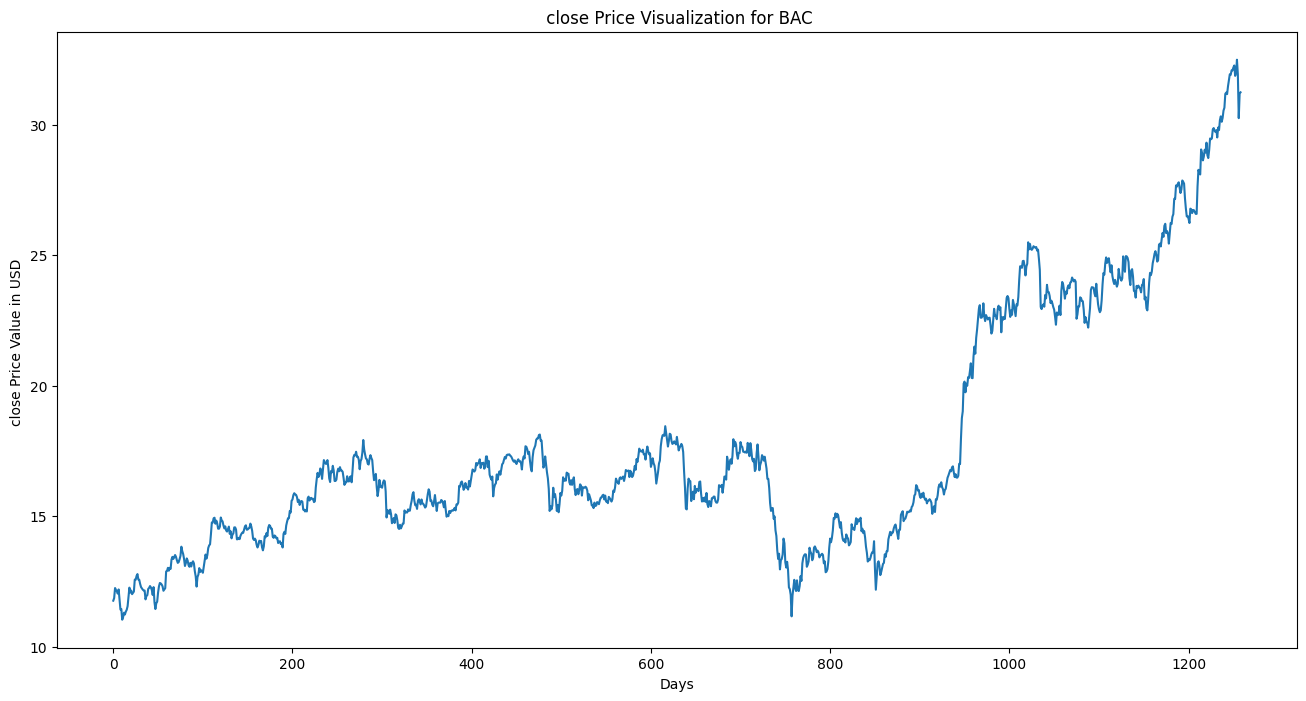

In [13]:
plot(filtered_df, 'BAC', 'close')

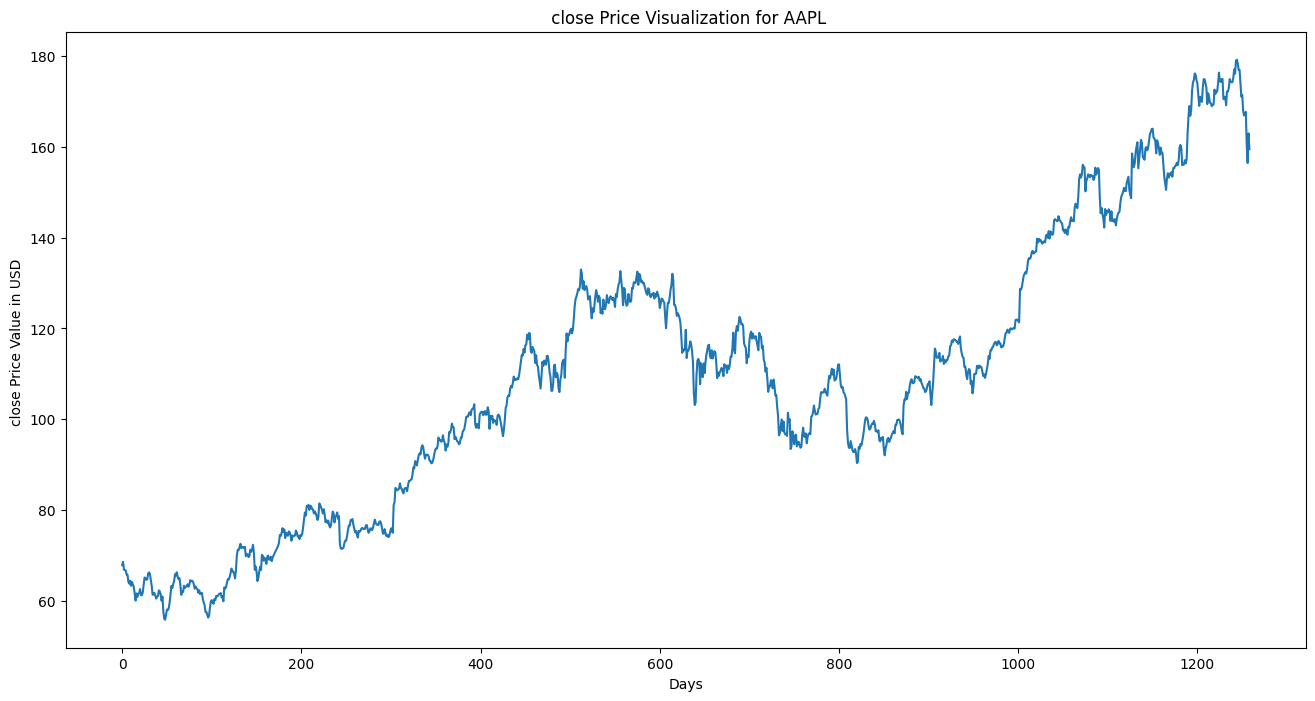

In [14]:
plot(filtered_df, 'AAPL', 'close')

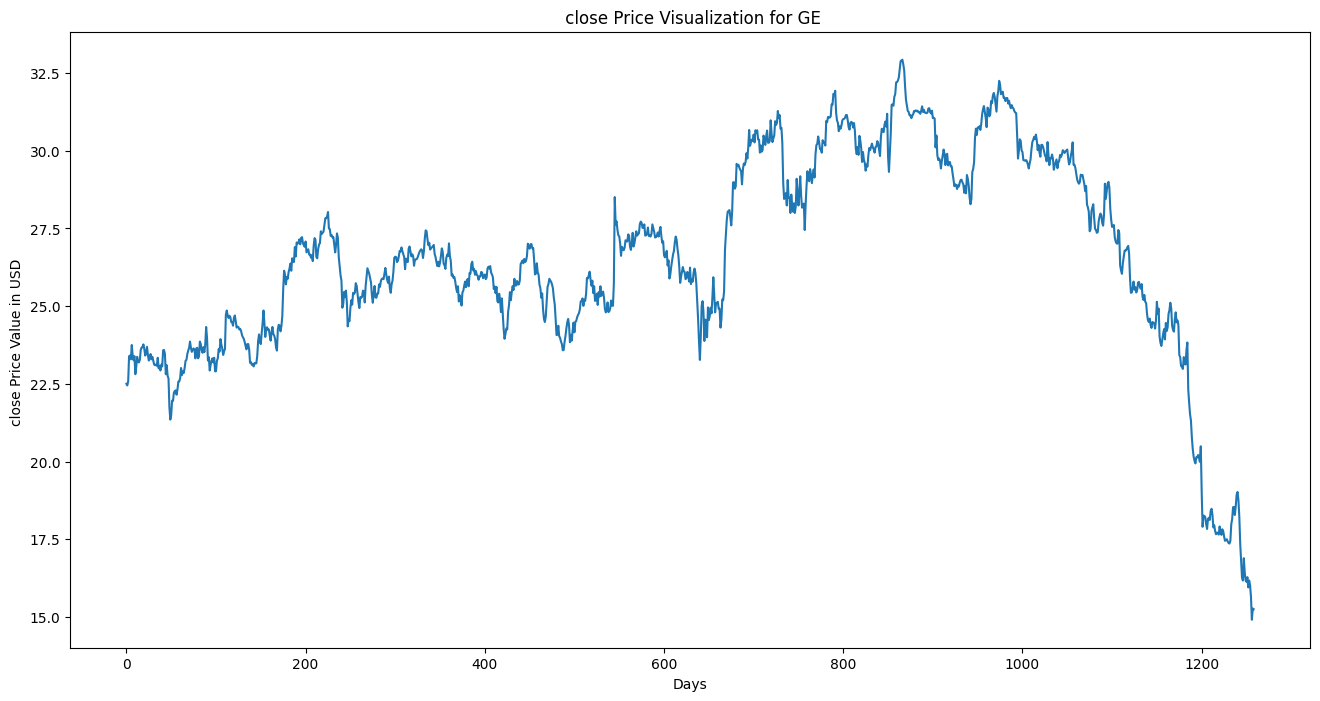

In [15]:
plot(filtered_df, 'GE', 'close')

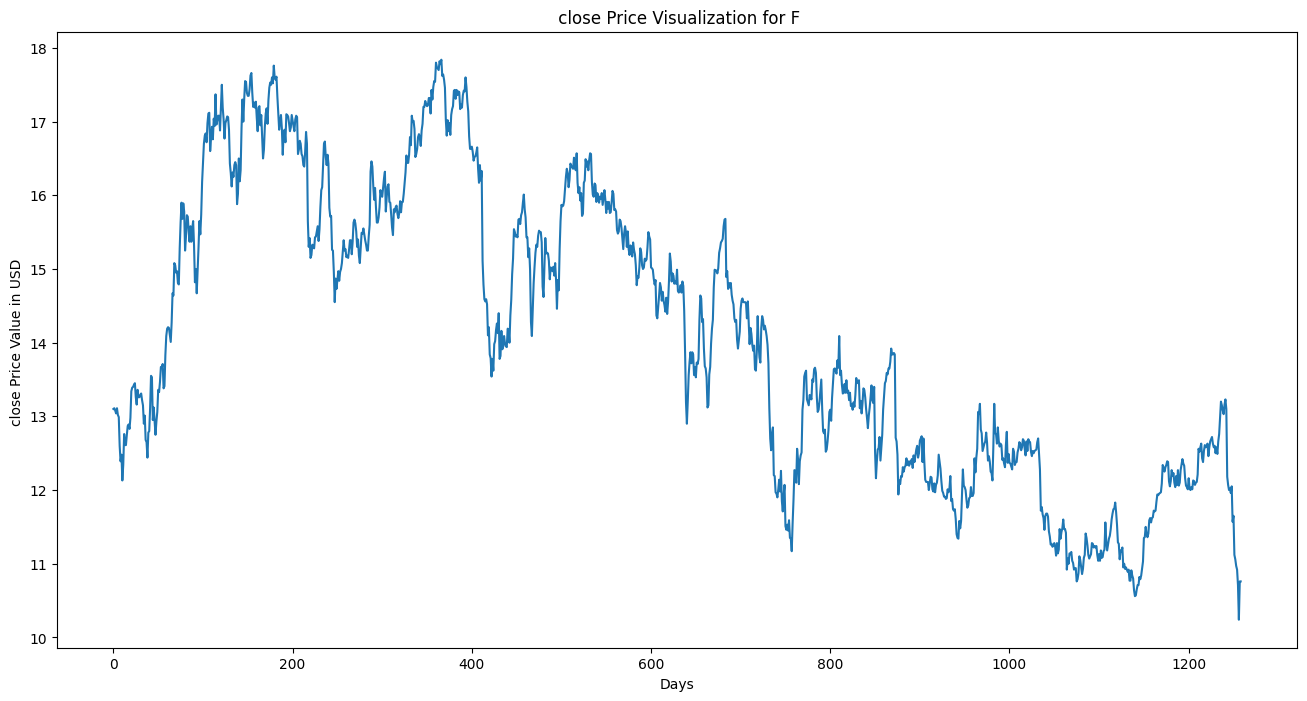

In [16]:
plot(filtered_df, 'F', 'close')

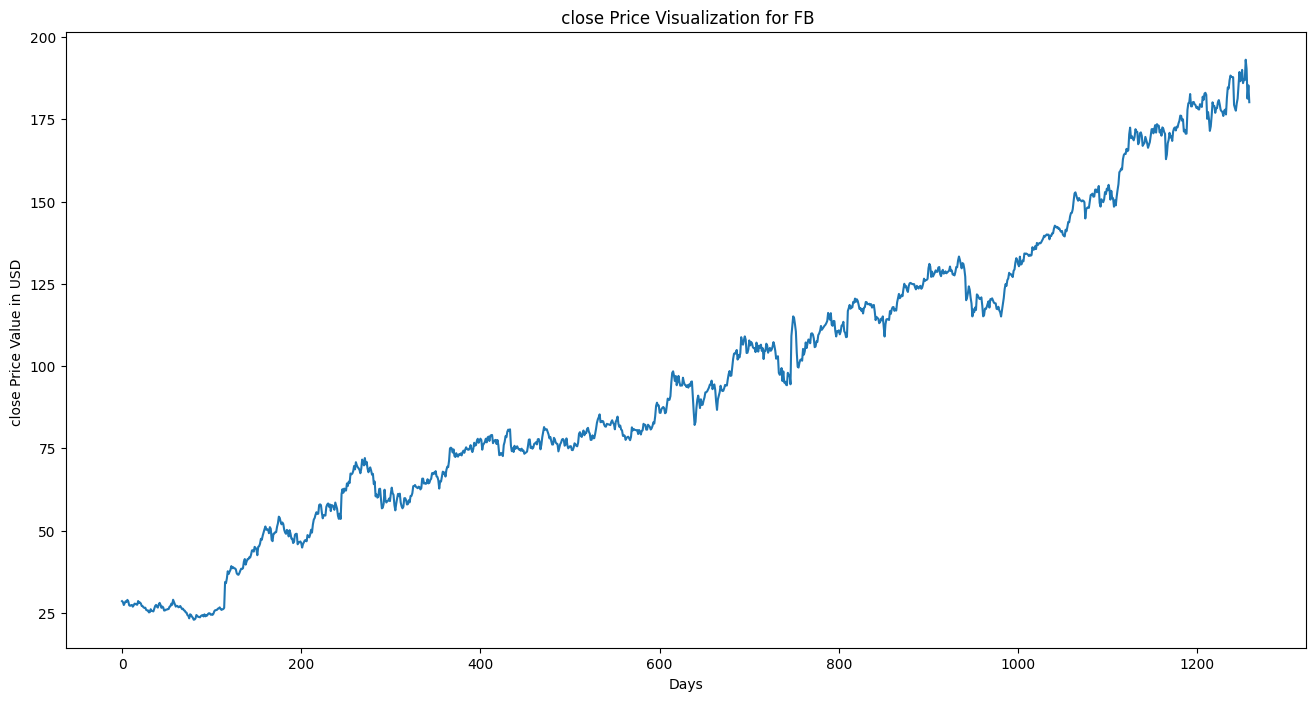

In [17]:
plot(filtered_df, 'FB', 'close')

Exploratory Data Analysis

In [18]:
def stock_basic_statistics(data, stocks):
    stock_stats = {}

    for stock in stocks:
        stock_data = data[data['Name'] == stock]
        closing_price = stock_data['close']
        opening_price = stock_data['open']
        highest_rate = stock_data['high'].max()
        lowest_rate = stock_data['low'].min()

        stock_stats[stock] = {
            'Closing Price': closing_price.mean(),
            'Opening Price': opening_price.mean(),
            'Highest Rate': highest_rate,
            'Lowest Rate': lowest_rate
        }

    return pd.DataFrame.from_dict(stock_stats, orient='index')
stock_stats = stock_basic_statistics(filtered_df, top_10_stocks)
print(stock_stats)

      Closing Price  Opening Price  Highest Rate  Lowest Rate
BAC       17.704178      17.706624         32.67      10.9800
AAPL     109.066698     109.055429        180.10      55.0142
GE        26.526342      26.529190         33.00      14.7100
F         14.102637      14.112669         18.12      10.1900
FB        96.478610      96.455059        195.32      22.6700
MSFT      51.063081      51.026394         96.07      27.2300
AMD        5.601863       5.604315         15.65       1.6100
MU        22.972593      22.985880         49.89       7.6400
INTC      31.831531      31.804532         50.85      20.1000
CSCO      27.743813      27.725160         42.98      19.9800


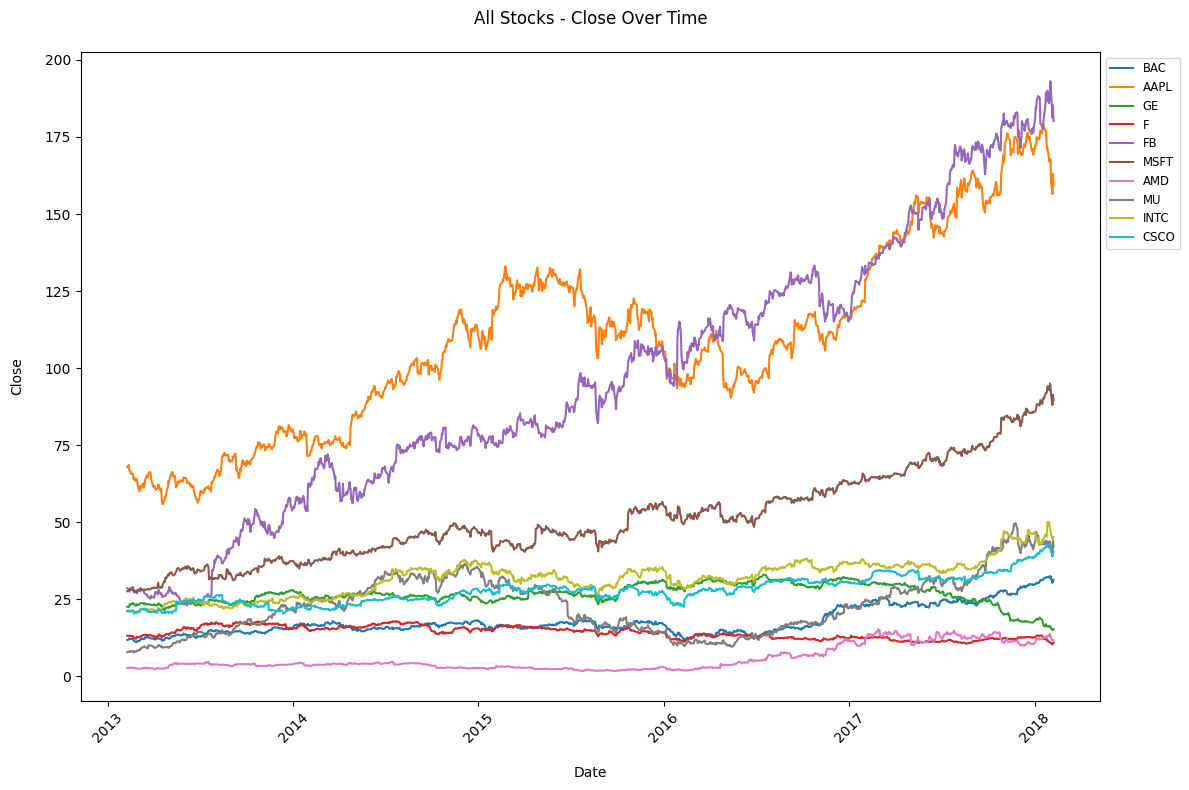

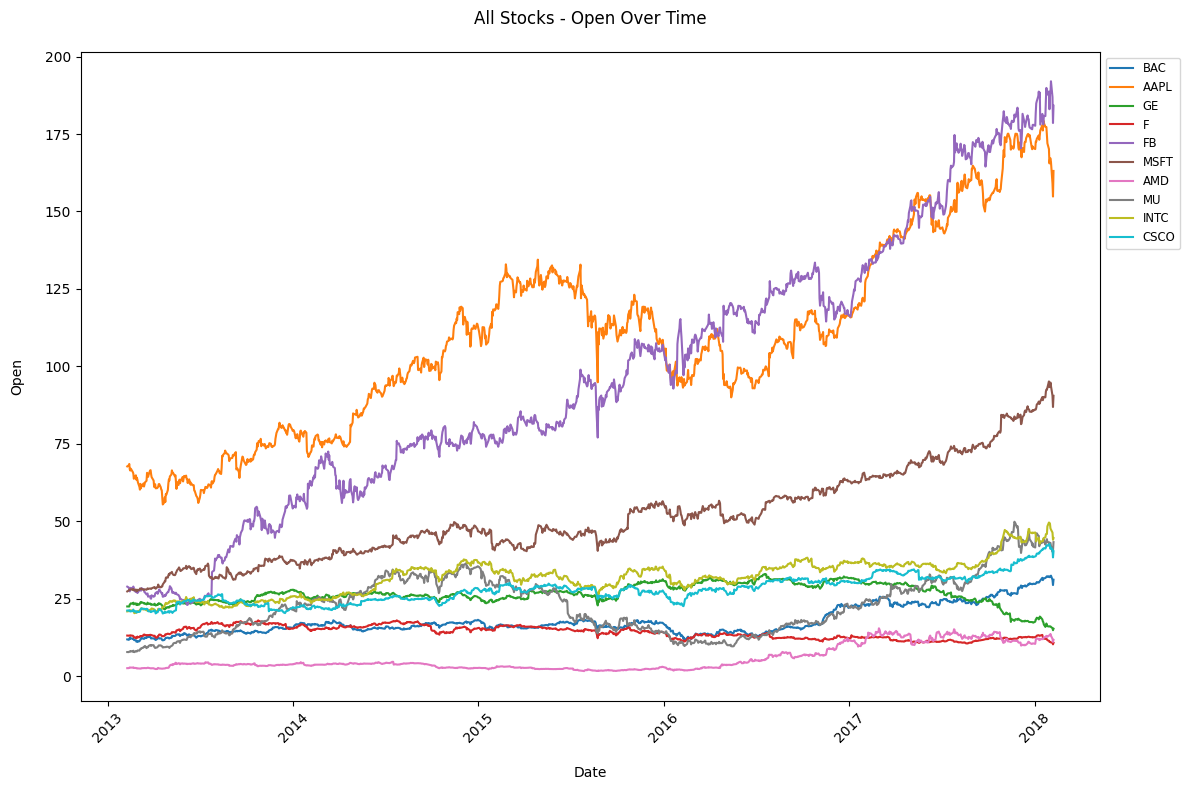

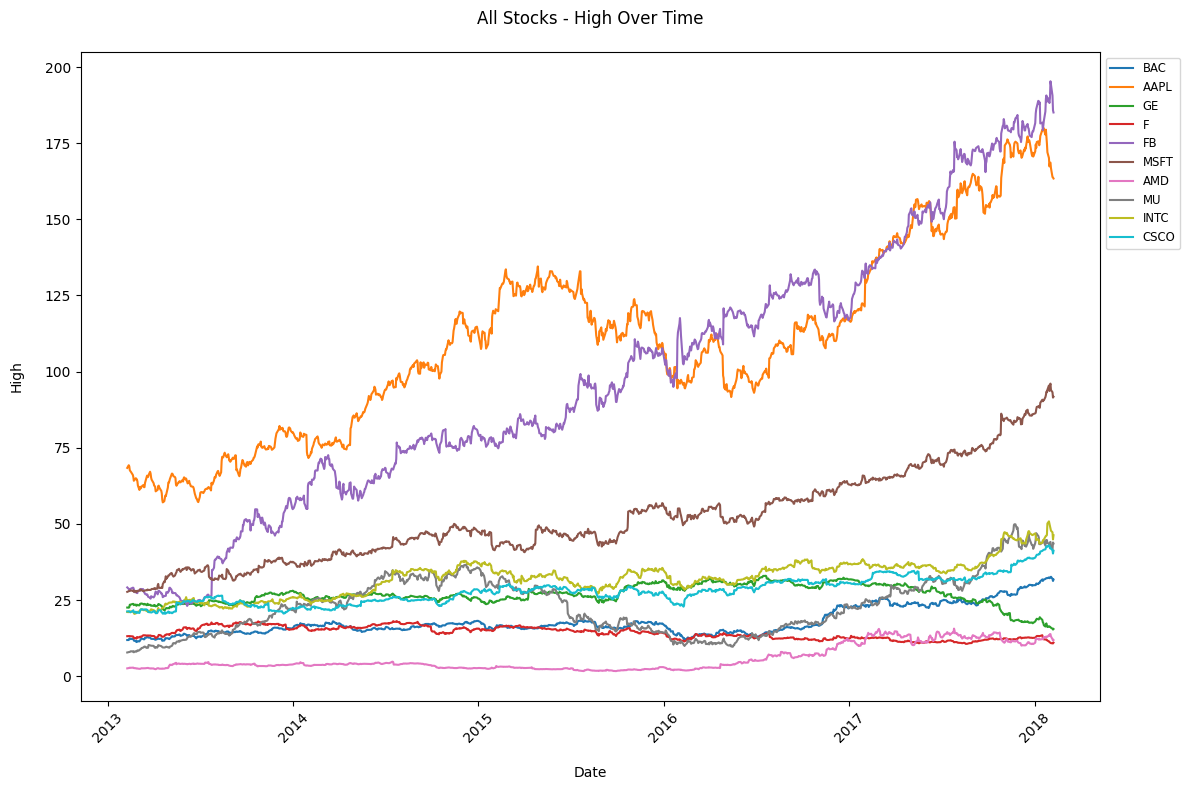

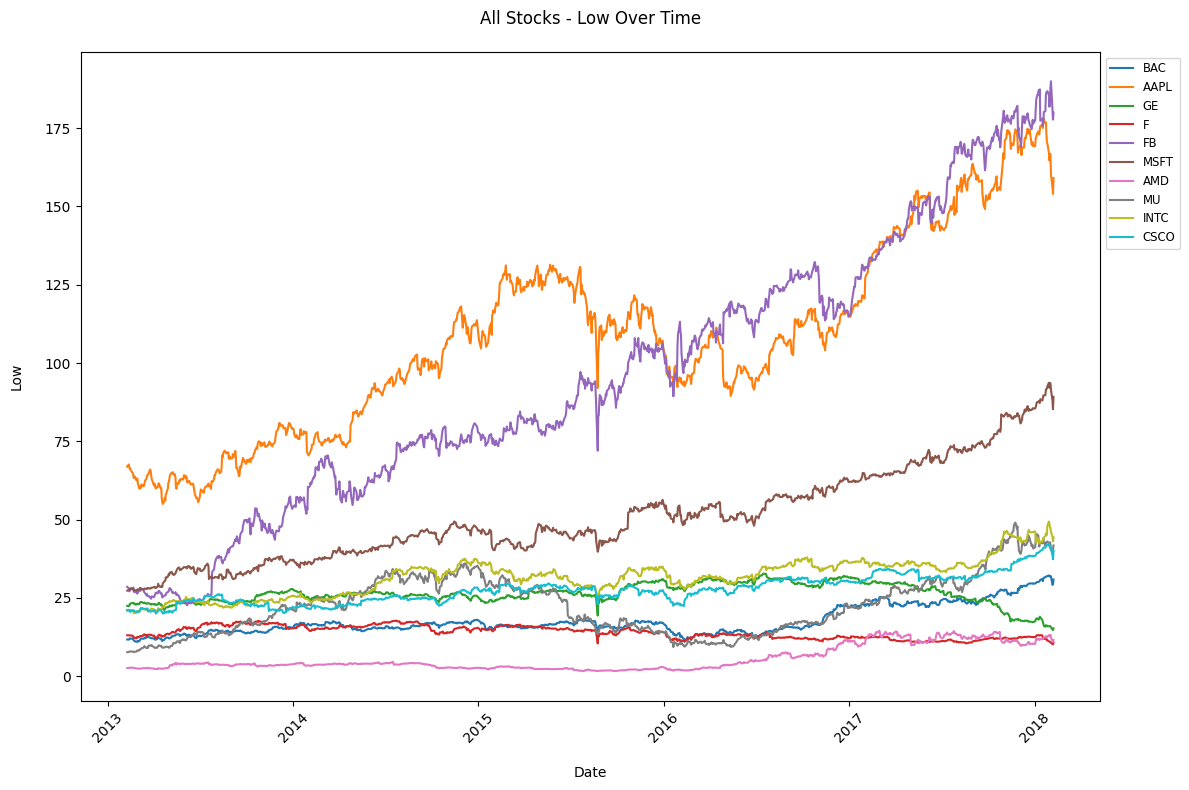

In [19]:
def visualize_all_stocks_prices(data, price_type):
    plt.figure(figsize=(12, 8))

    for stock in top_10_stocks:
        stock_data = data[data['Name'] == stock]
        plt.plot(stock_data['date'], stock_data[price_type], label=stock)

    plt.title(f'All Stocks - {price_type.capitalize()} Over Time', pad=20)
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(price_type.capitalize(), labelpad=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize Prices Over Time for All Stocks
price_types = ['close', 'open', 'high', 'low']
for price_type in price_types:
    visualize_all_stocks_prices(filtered_df, price_type)

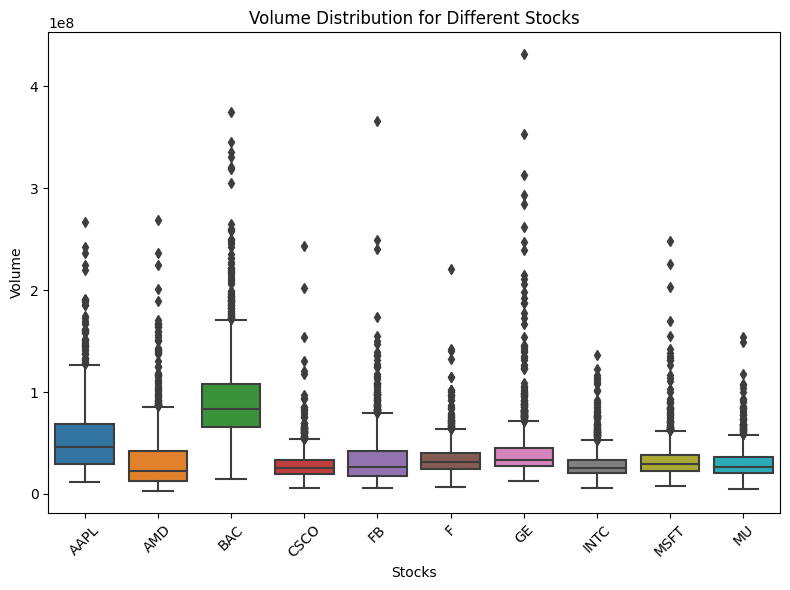

In [20]:
# Box plot for volume to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_df, x='Name', y='volume')
plt.title('Volume Distribution for Different Stocks')
plt.xlabel('Stocks')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-21-1a19726109f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[filtered_df.columns[filtered_df.columns.get_loc('date')]] = pd.to_datetime(filtered_df['date'])


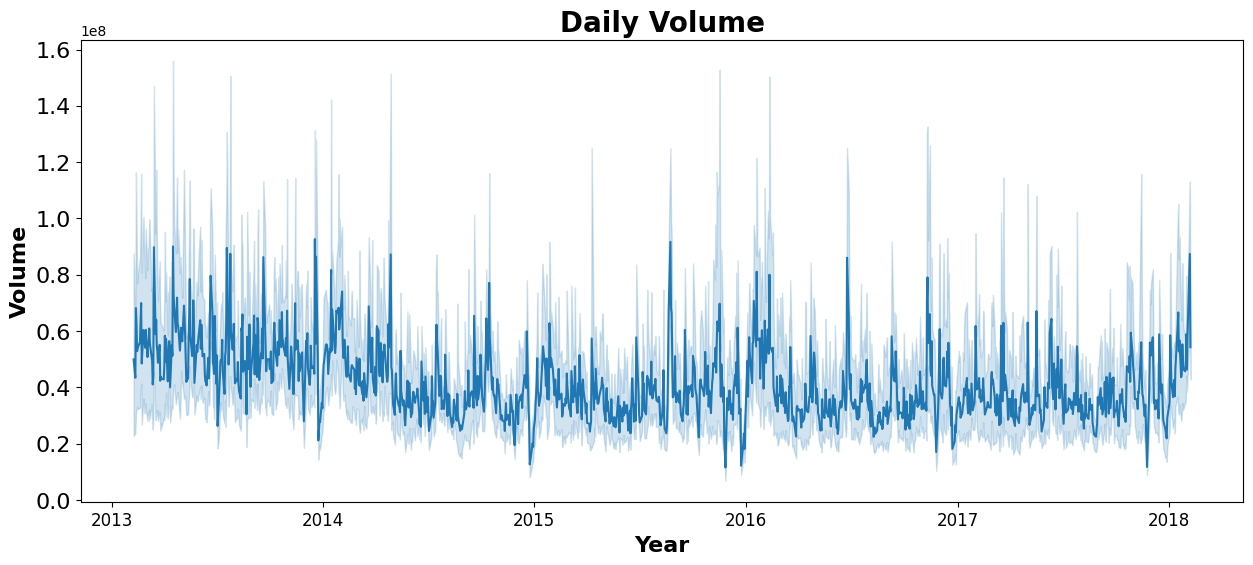

In [21]:
# Convert 'Date' column to datetime because it's not already in datetime format
filtered_df[filtered_df.columns[filtered_df.columns.get_loc('date')]] = pd.to_datetime(filtered_df['date'])

# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=filtered_df, x='date', y='volume')

# Formatting
ax.set_title('Daily Volume', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Volume', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=12)  # Adjusting X-axis label size if needed
plt.show()

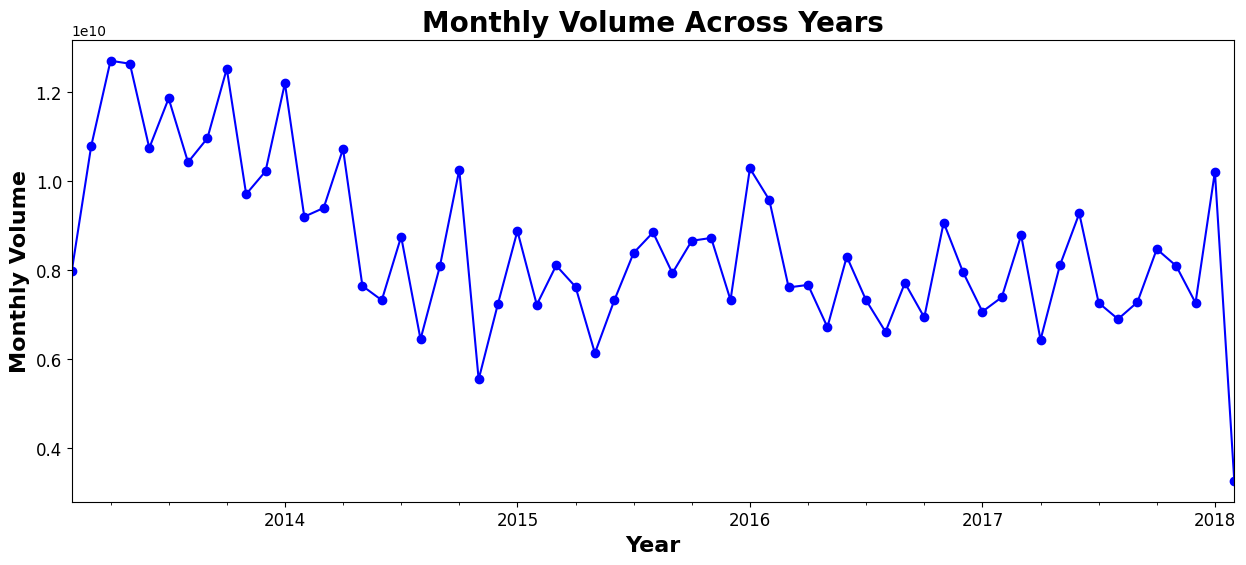

In [22]:
# New DataFrame to hold the monthly volume data
monthly_volume_df = filtered_df.copy()

# Convert 'Date' column to datetime if it's not already in datetime format
monthly_volume_df['date'] = pd.to_datetime(monthly_volume_df['date'])

# Set 'Date' column as the DataFrame's index for monthly volume data
monthly_volume_df.set_index('date', inplace=True)

# Resample data to monthly frequency and calculate the sum of volume for each month
monthly_volume = monthly_volume_df.resample('M')['volume'].sum()

# Plot Monthly Volume against Year
fig, ax = plt.subplots(figsize=(15, 6))
monthly_volume.plot(ax=ax, color='blue', marker='o')

# Formatting
ax.set_title('Monthly Volume Across Years', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Monthly Volume', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=12)  # Adjust Y-axis label size if needed
plt.tick_params(axis='x', which='major', labelsize=12)  # Adjust X-axis label size if needed

plt.show()

SEASONALITY

<ipython-input-23-3adceacc8cde>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = pd.to_datetime(filtered_df['date'])
<ipython-input-23-3adceacc8cde>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Month'] = filtered_df['date'].dt.month
<ipython-input-23-3adceacc8cde>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

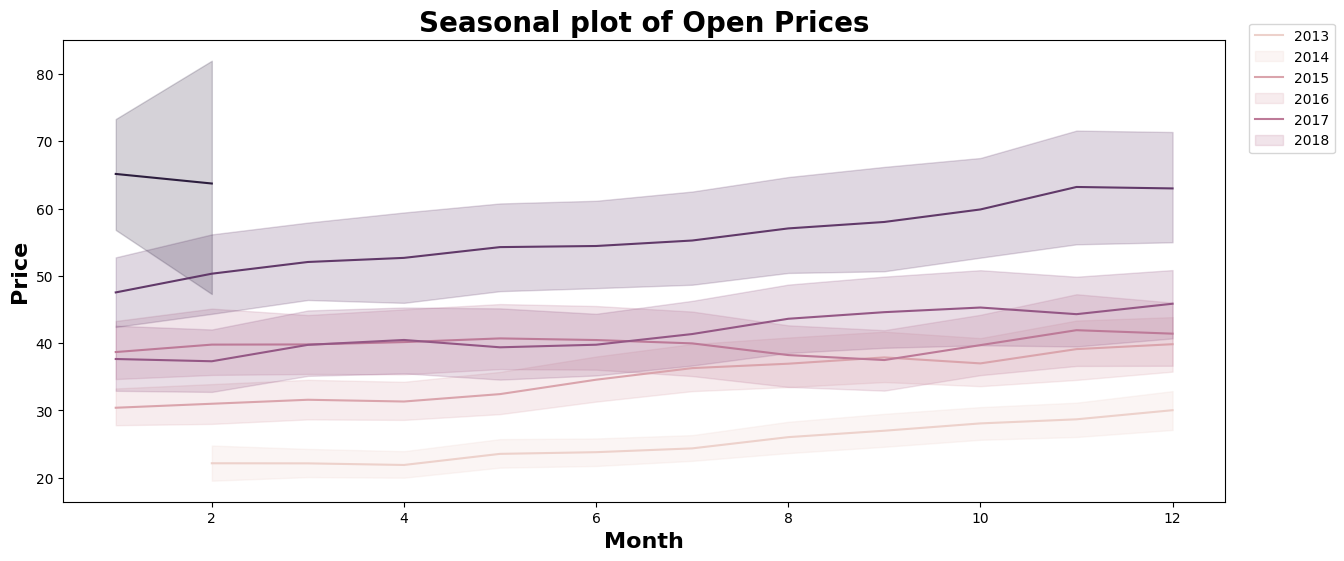

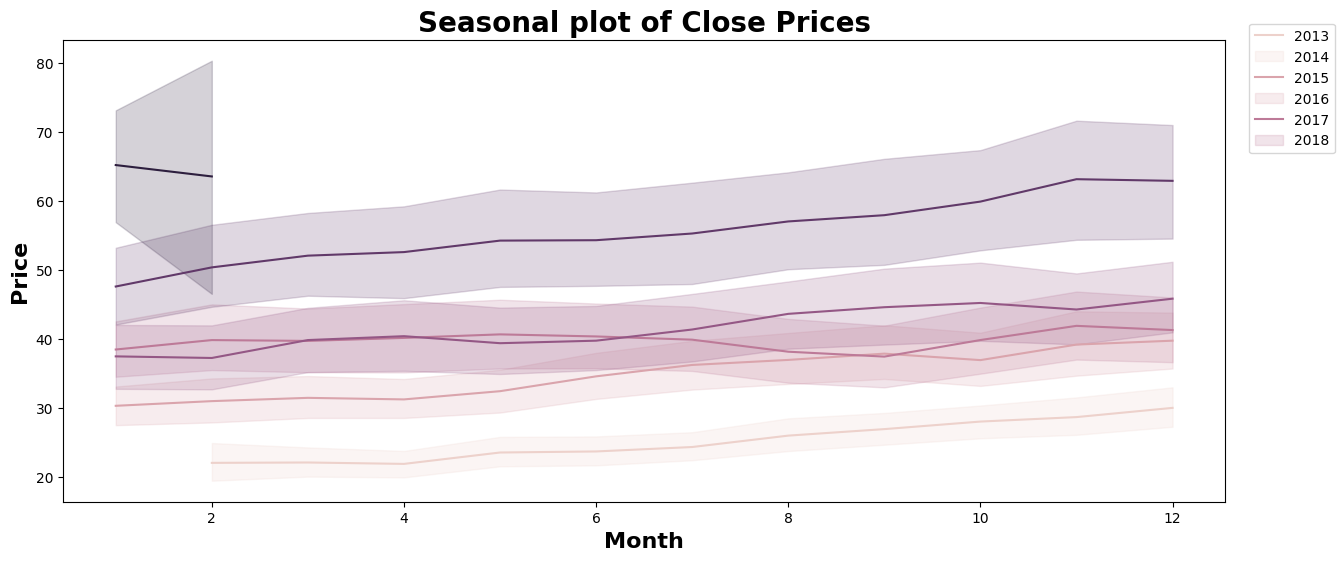

In [23]:
# Set the variables to plot
variables = ['open', 'close']  # Assuming 'open' and 'close' are the column names for opening and closing prices

# Convert 'Date' column to datetime if it's not already in datetime format
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract month and year information using .dt accessor with .loc to set values
filtered_df.loc[:, 'Month'] = filtered_df['date'].dt.month
filtered_df.loc[:, 'Year'] = filtered_df['date'].dt.year

# Create separate plots for 'Open' and 'Close' prices
for variable in variables:
    plt.figure(figsize=(15, 6))  # Create a new figure for each plot

    # Plot the seasonal line plot for each variable
    sns.lineplot(data=filtered_df, x='Month', y=variable, hue='Year')

    # Format the plot
    plt.title(f'Seasonal plot of {variable.capitalize()} Prices', fontsize=20, loc='center', fontweight='bold')
    plt.xlabel('Month', fontsize=16, fontweight='bold')
    plt.ylabel('Price', fontsize=16, fontweight='bold')
    plt.legend(labels=[str(year) for year in filtered_df['Year'].unique()], bbox_to_anchor=(1.1, 1.05))

    plt.show()


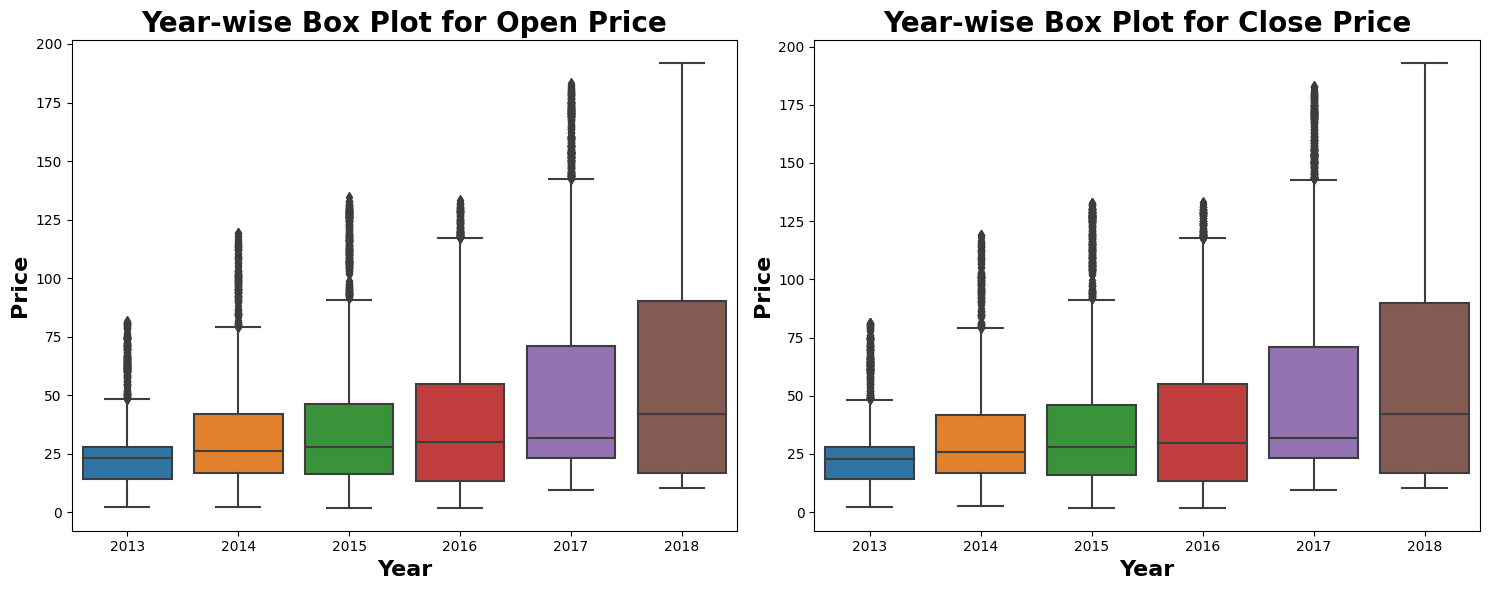

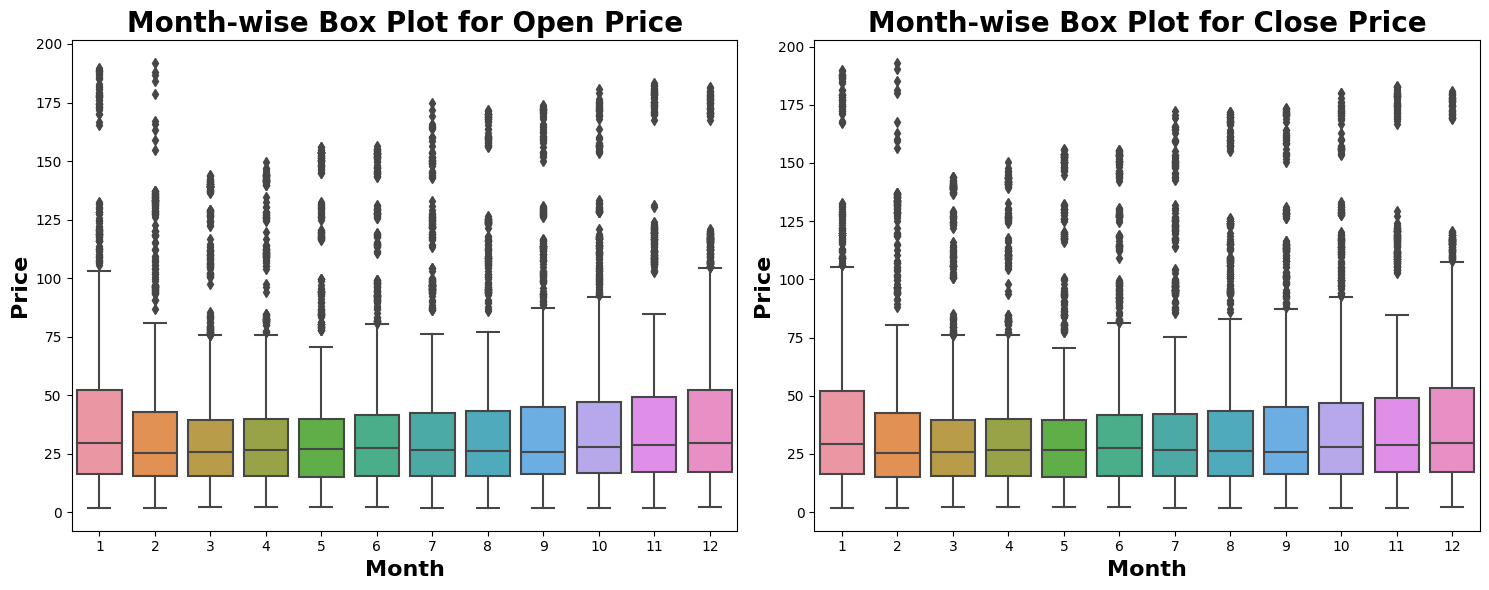

In [24]:
# Create a separate figure for the year-wise box plot for both 'Open' and 'Close' prices
plt.figure(figsize=(15, 6))

# Plot the year-wise box plot for both 'Open' and 'Close' prices
for i, variable in enumerate(variables, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=filtered_df, x='Year', y=variable)

    # Format the year-wise box plot
    plt.title(f'Year-wise Box Plot for {variable.capitalize()} Price', fontsize=20, loc='center', fontweight='bold')
    plt.xlabel('Year', fontsize=16, fontweight='bold')
    plt.ylabel('Price', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Create another separate figure for the month-wise box plot for both 'Open' and 'Close' prices
plt.figure(figsize=(15, 6))

# Plot the month-wise box plot for both 'Open' and 'Close' prices
for i, variable in enumerate(variables, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=filtered_df, x='Month', y=variable)

    # Format the month-wise box plot
    plt.title(f'Month-wise Box Plot for {variable.capitalize()} Price', fontsize=20, loc='center', fontweight='bold')
    plt.xlabel('Month', fontsize=16, fontweight='bold')
    plt.ylabel('Price', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

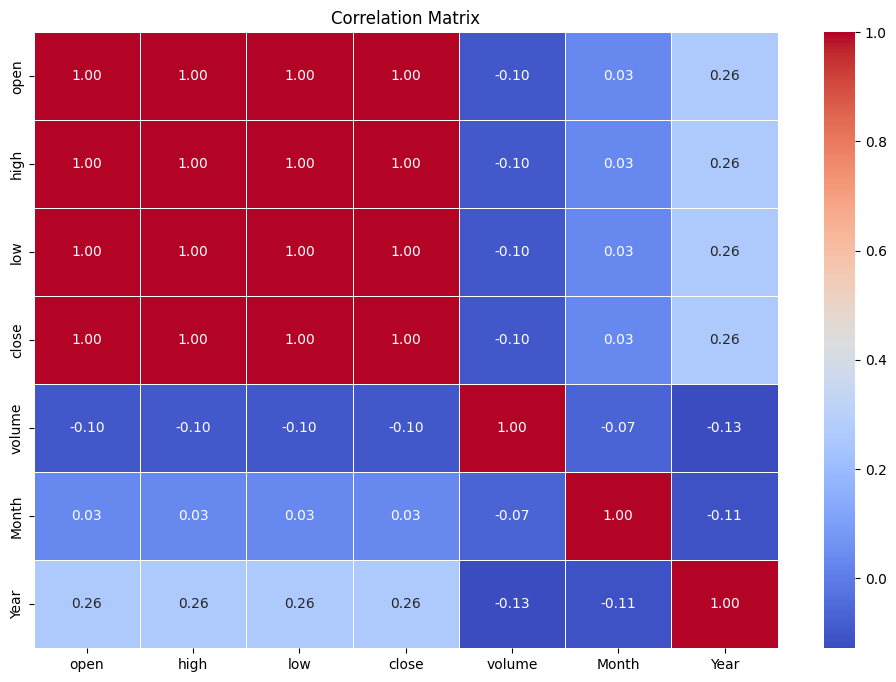

In [25]:
# Compute the correlation matrix for numeric columns
numeric_columns = filtered_df.select_dtypes(include=np.number).columns
correlation_matrix = filtered_df[numeric_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

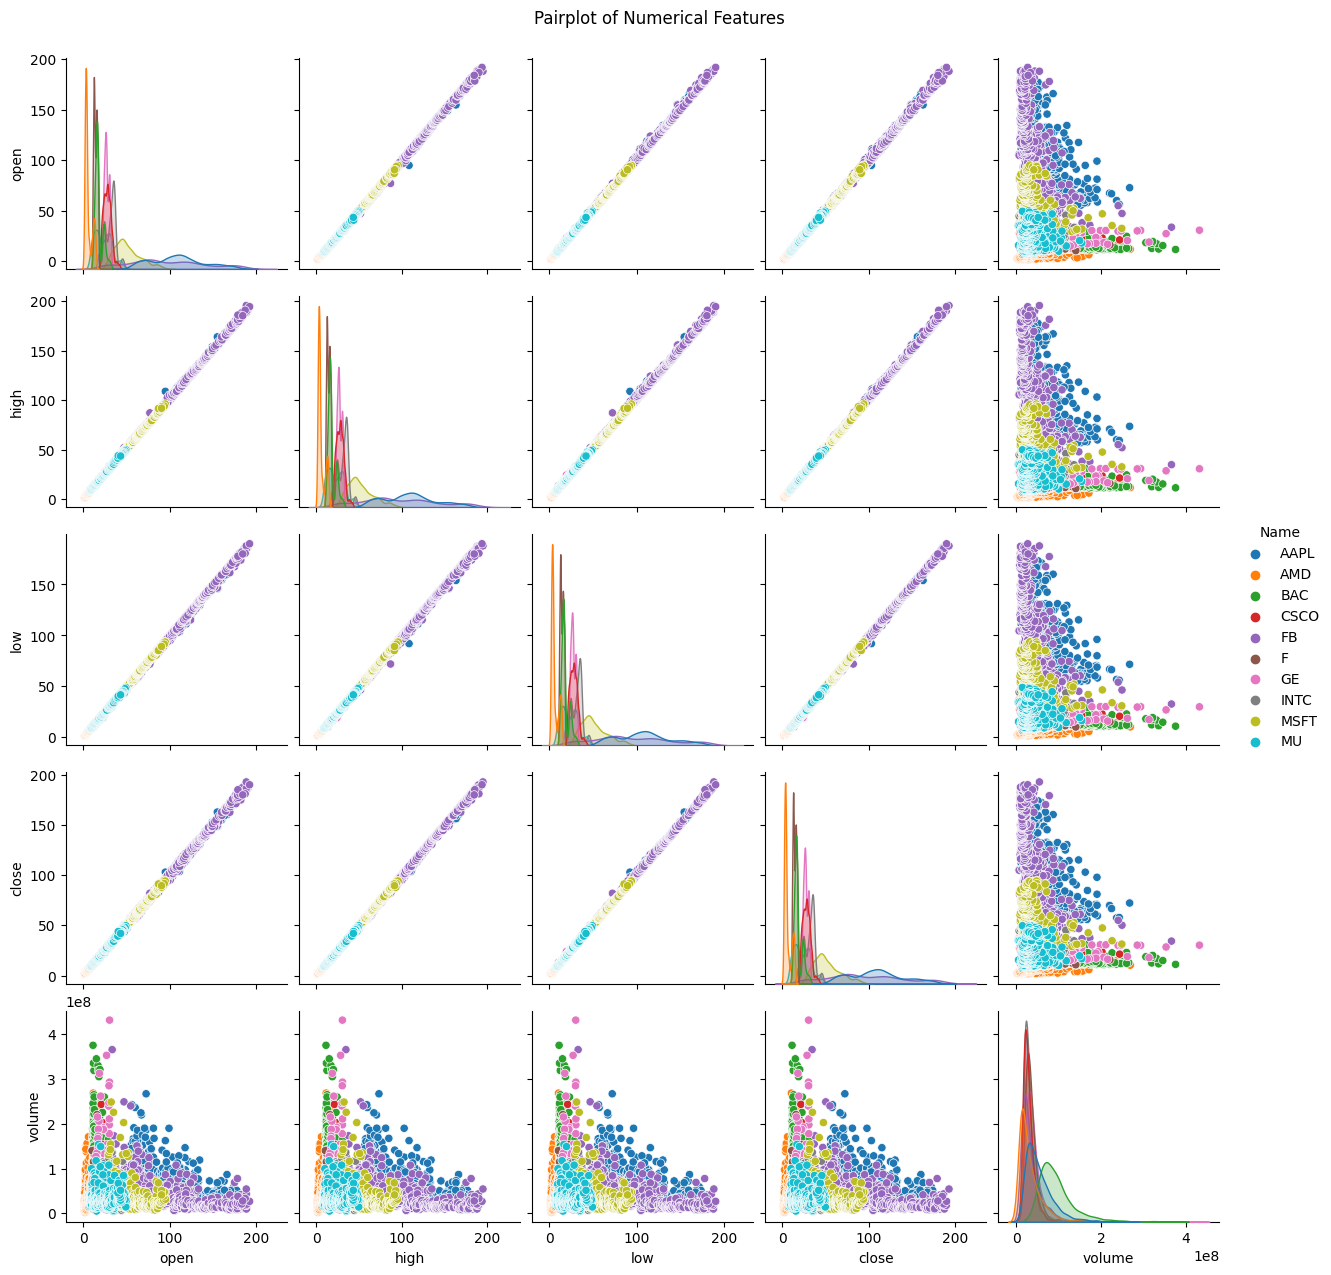

In [26]:
# Create a pairplot
sns.pairplot(filtered_df, hue='Name', vars=['open', 'high', 'low', 'close', 'volume'])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

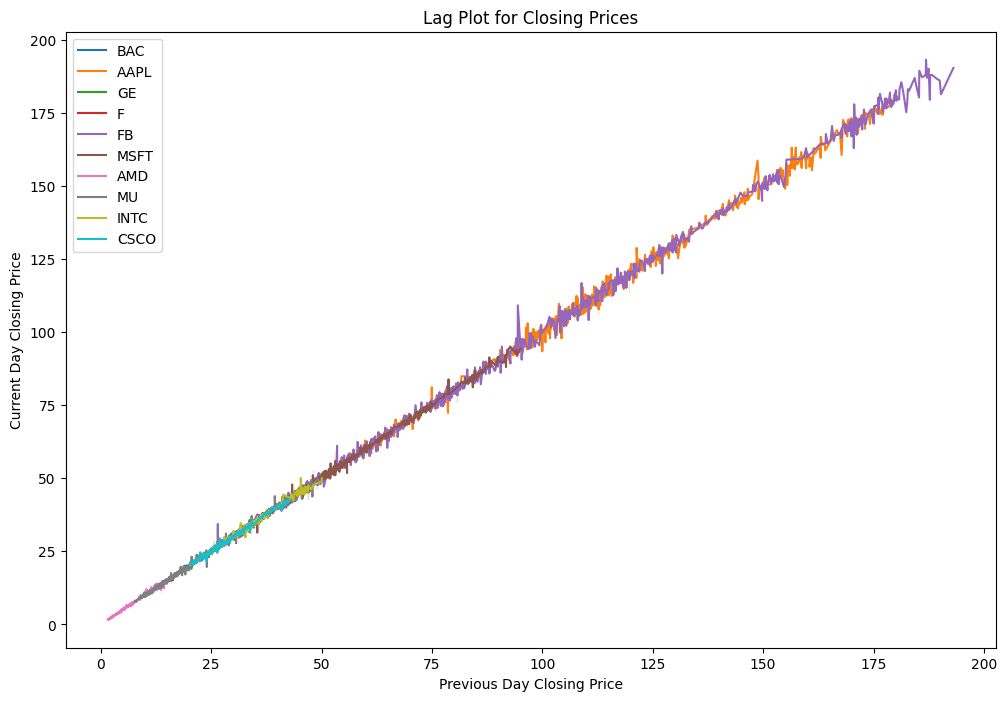

In [27]:
# Create lag plots for 'close' price
plt.figure(figsize=(12, 8))
for stock in top_10_stocks:
    stock_data = filtered_df[filtered_df['Name'] == stock]
    sns.lineplot(data=stock_data, x=stock_data['close'].shift(1), y='close', label=stock)

plt.title('Lag Plot for Closing Prices')
plt.xlabel('Previous Day Closing Price')
plt.ylabel('Current Day Closing Price')
plt.legend()
plt.show()

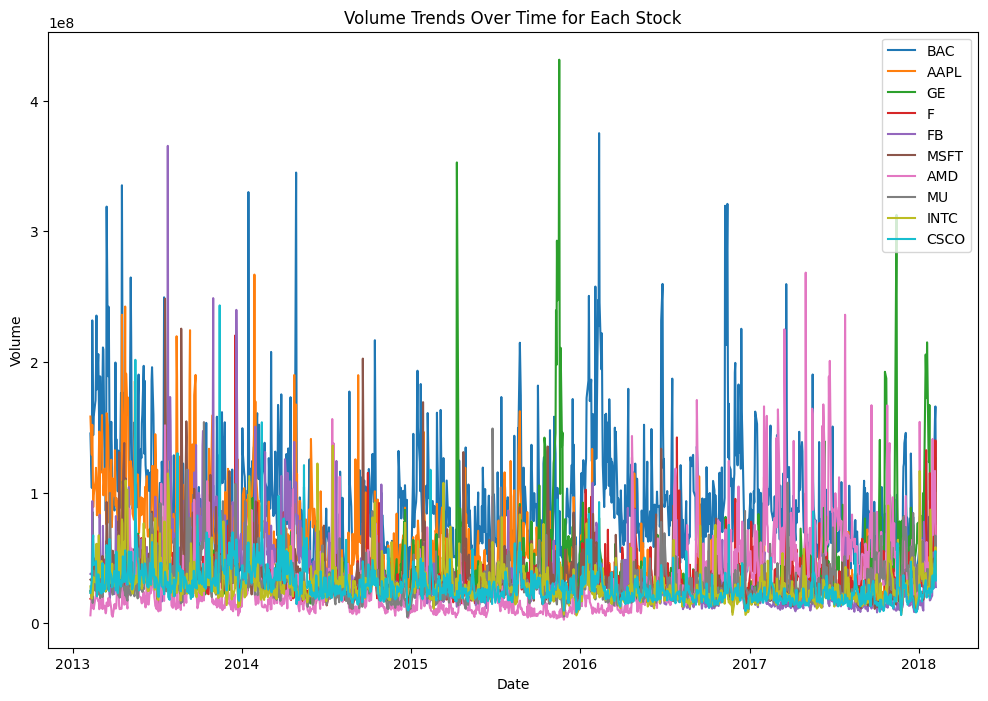

In [28]:
# Plot the trends in trading volume over time for each stock
plt.figure(figsize=(12, 8))
for stock in top_10_stocks:
    stock_data = filtered_df[filtered_df['Name'] == stock]
    sns.lineplot(data=stock_data, x='date', y='volume', label=stock)

plt.title('Volume Trends Over Time for Each Stock')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

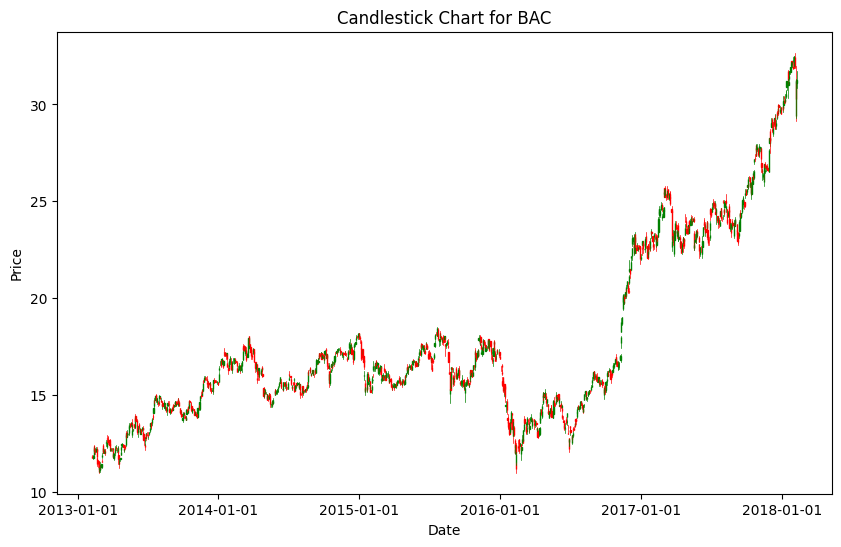

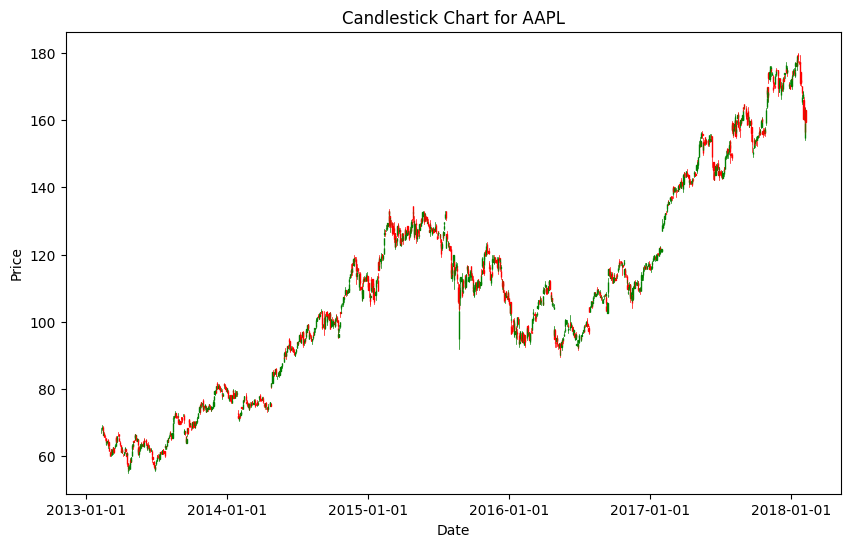

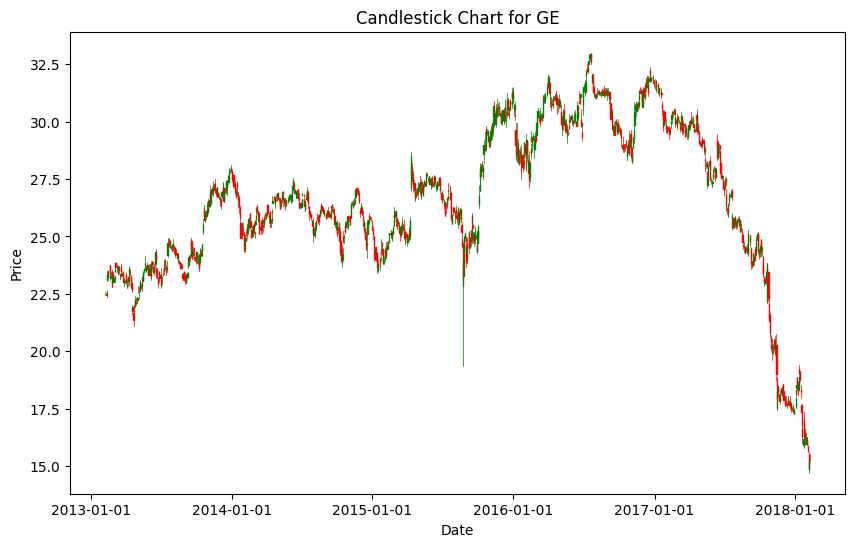

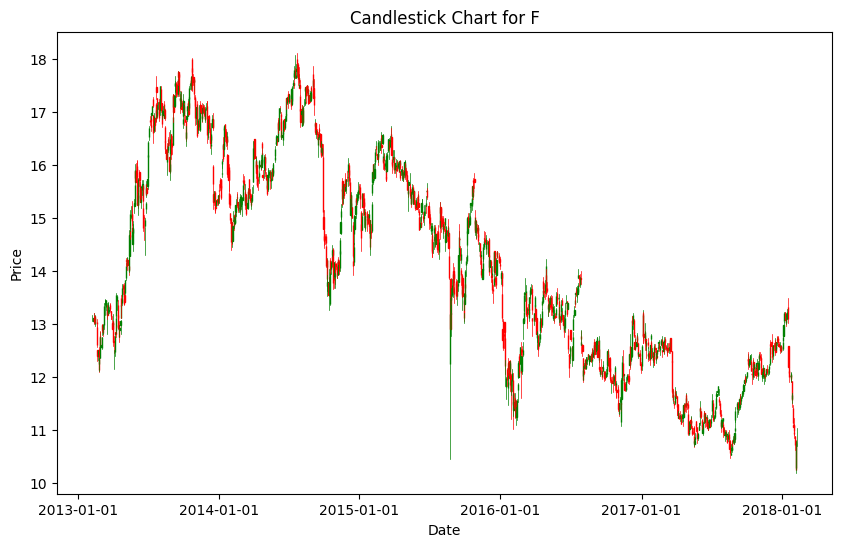

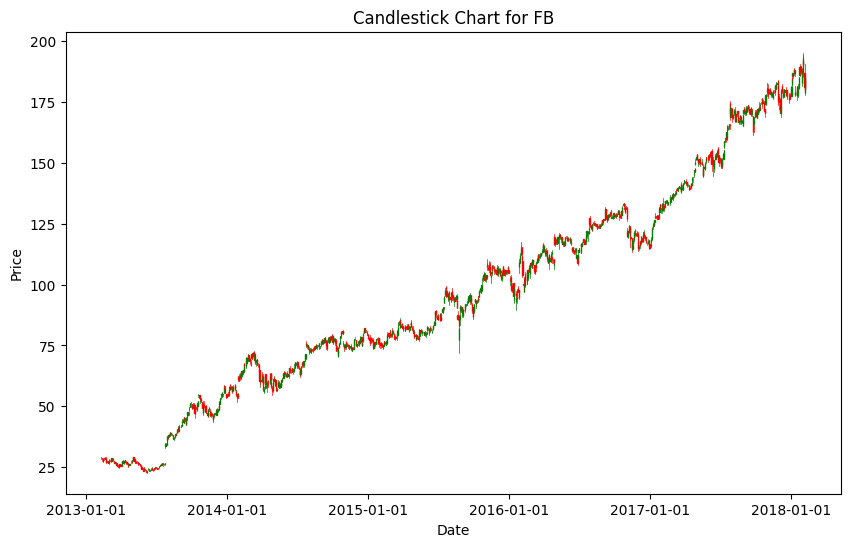

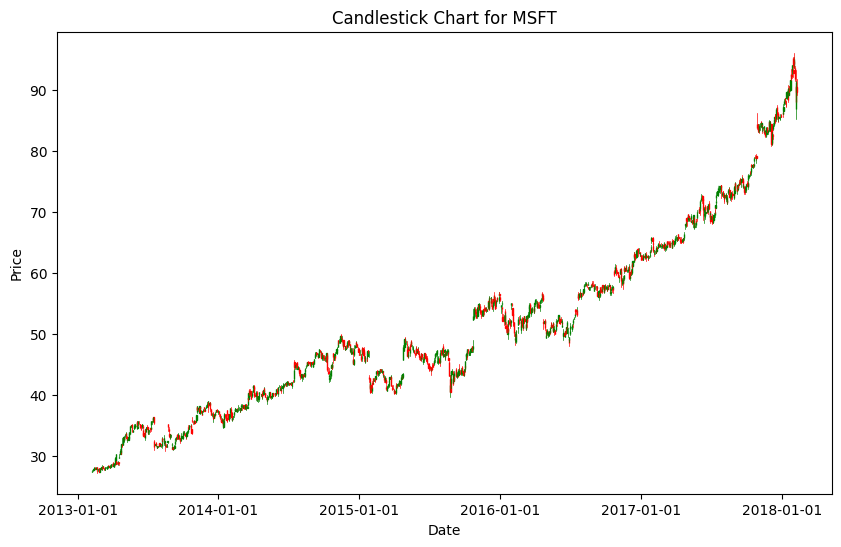

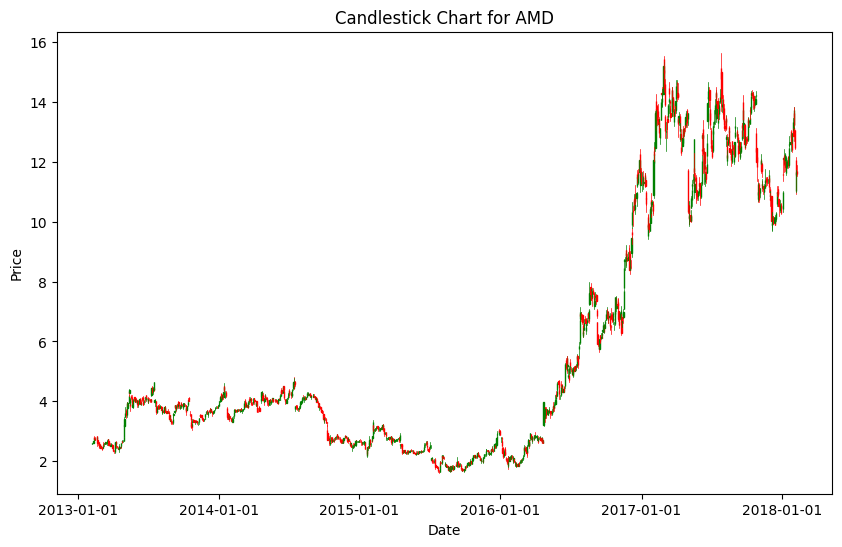

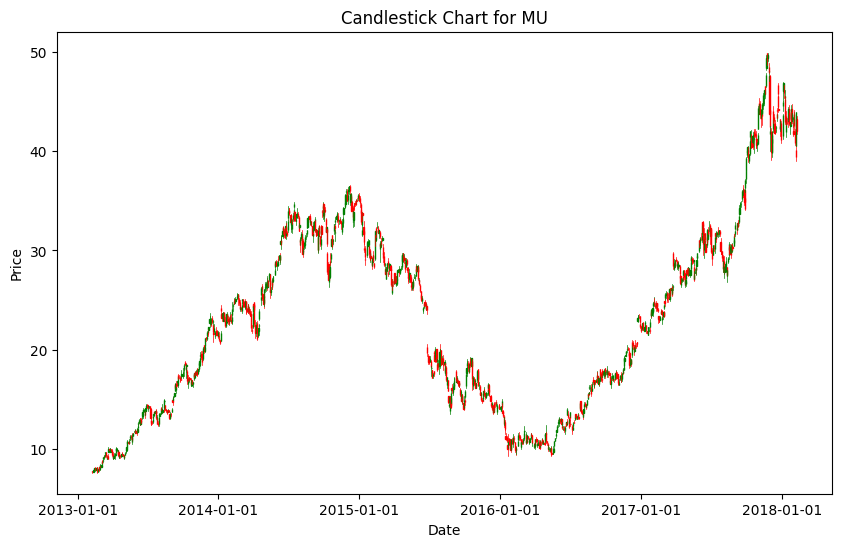

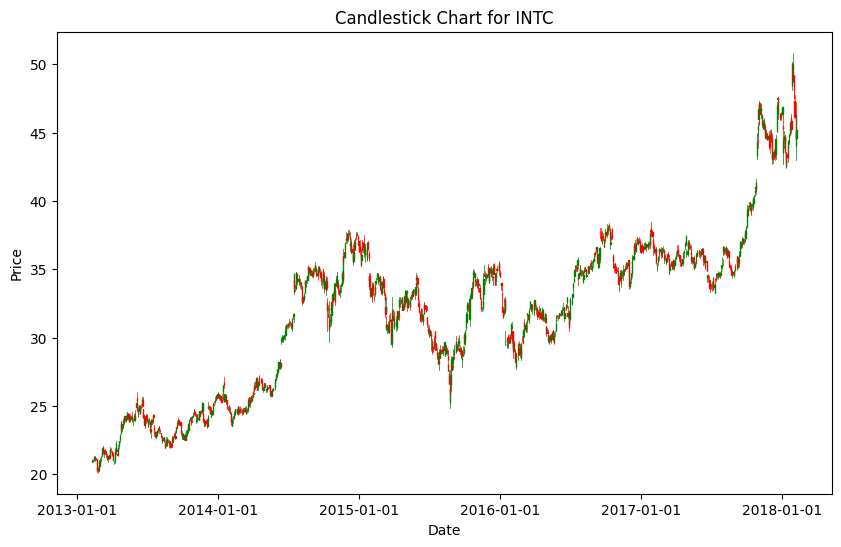

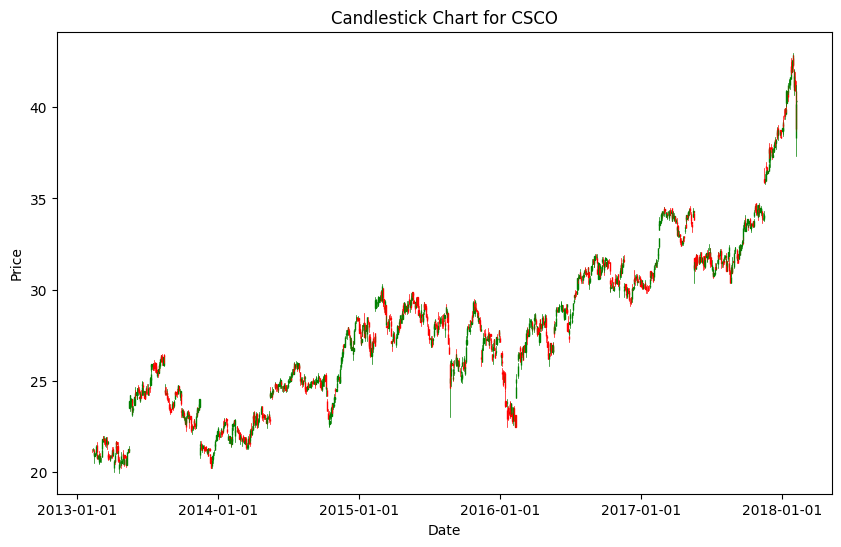

In [29]:
for stock in top_10_stocks:
    stock_data = filtered_df[filtered_df['Name'] == stock].copy()  # Create a copy

    # Use .loc to avoid SettingWithCopyWarning
    stock_data.loc[:, 'date_num'] = mdates.date2num(stock_data['date'])

    ohlc_data = stock_data[['date_num', 'open', 'high', 'low', 'close']].values

    # Create candlestick chart
    fig, ax = plt.subplots(figsize=(10, 6))
    candlestick_ohlc(ax, ohlc_data, width=0.6, colorup='g', colordown='r')

    # Format x-axis as dates
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Candlestick Chart for {stock}')

    # Show the plot
    plt.show()

## Linear Regression Model

In [30]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * np.dot(X.T, (model - y))
            db = (1/n_samples) * np.sum(model - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [31]:
# Selecting Features and Target
X = df[['open', 'high', 'low', 'volume']].values
y = df['close'].values

# Normalizing Features
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234)

In [32]:
# Initializing and training the model
reg = LinearRegression(learning_rate=0.01, n_iterations=1000)
reg.fit(X_train, y_train)

# Predictions
predictions = reg.predict(X_test)

In [33]:
# Evaluating the model
mse_value = mean_squared_error(y_test, predictions)
r2_value = r2_score(y_test, predictions)

print("MSE for Linear Regression:", mse_value)
print("R-squared for Linear Regression:", r2_value)

MSE for Linear Regression: 1.2793017087763052
R-squared for Linear Regression: 0.9998898197220879


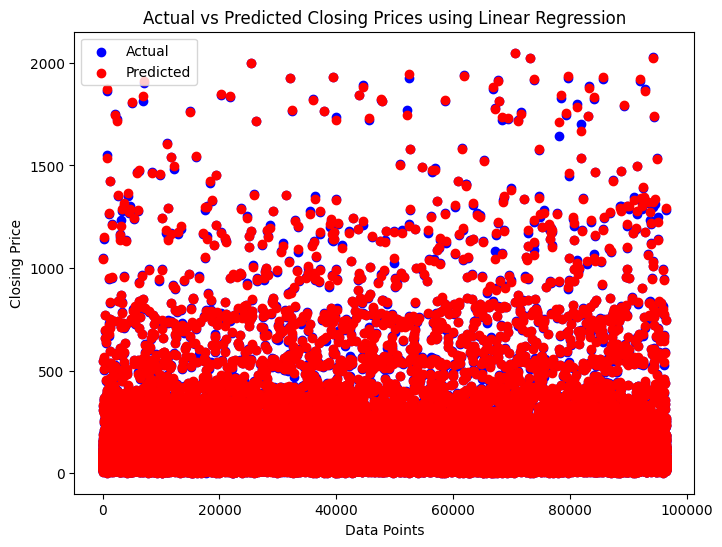

In [34]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices using Linear Regression")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

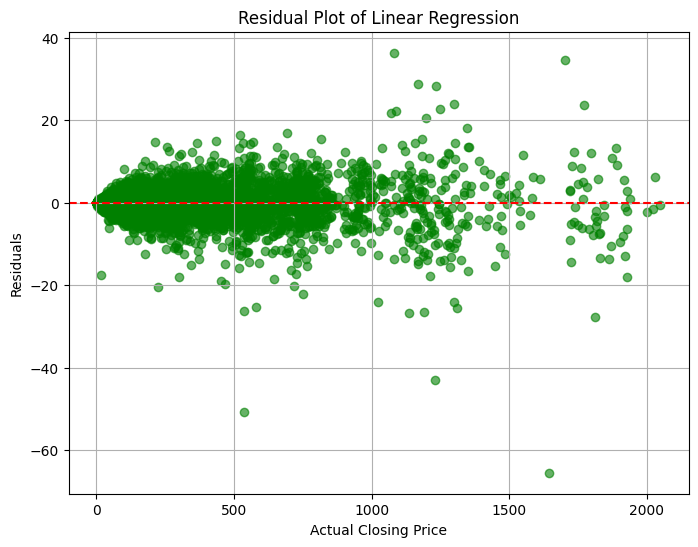

In [35]:
residuals = y_test - predictions

plt.figure(figsize=(8, 6))

# Scatter plot of residuals
plt.scatter(y_test, residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot of Linear Regression")
plt.xlabel("Actual Closing Price")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

Linear Regression Coefficients: [ 3.57840530e+01  3.58650135e+01  3.58619953e+01 -3.91523180e-03]
Linear Regression Intercept: 84.60023178384863


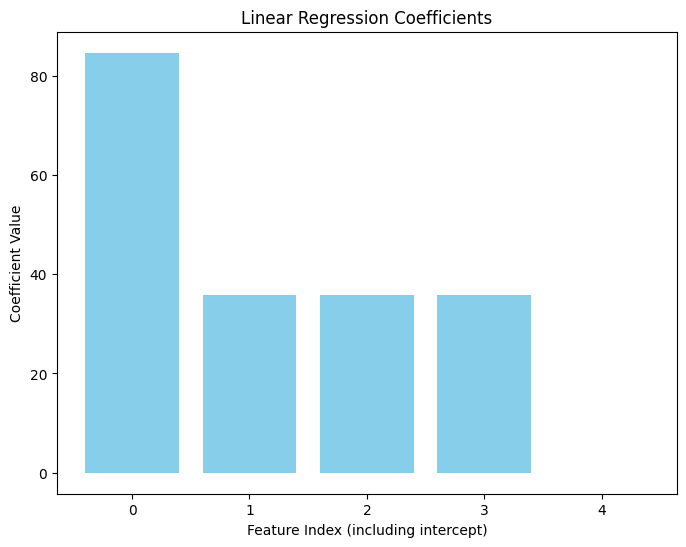

In [36]:
custom_reg = LinearRegression()
custom_reg.fit(X_train, y_train)

# Get coefficients and intercept
coefficients = custom_reg.weights
intercept = custom_reg.bias

# Print the coefficients
print("Linear Regression Coefficients:", coefficients)
print("Linear Regression Intercept:", intercept)

# Plotting the coefficients
n_features = len(coefficients)
plt.figure(figsize=(8, 6))
plt.bar(range(n_features + 1), np.concatenate(([intercept], coefficients)), color='skyblue')
plt.xlabel('Feature Index (including intercept)')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.show()

## Ridge Regression Model

In [37]:
# Building and fitting the Ridge Regression Model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predicting the values
y_pred_ridge = ridge.predict(X_test)
print(y_pred_ridge)

[ 21.27265791  48.03388829  82.88078293 ...  41.16475189  32.64236376
 101.53319882]


In [38]:
# Calculating metrics
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Mean Squared Error for Decision Tree Model: ", mse_ridge)
print("R-squared for Decision Tree Model: ", r2_ridge )

Ridge Regression Mean Squared Error for Decision Tree Model:  0.5417652459607915
R-squared for Decision Tree Model:  0.9999533402910716


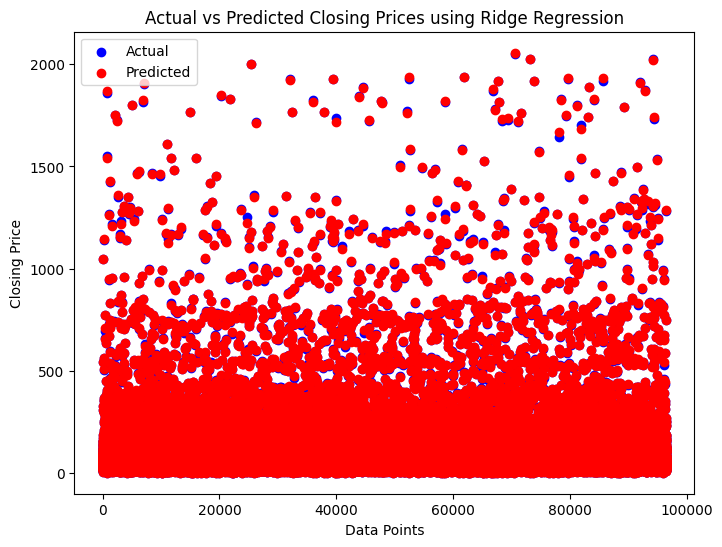

In [39]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred_ridge)), y_pred_ridge, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices using Ridge Regression")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

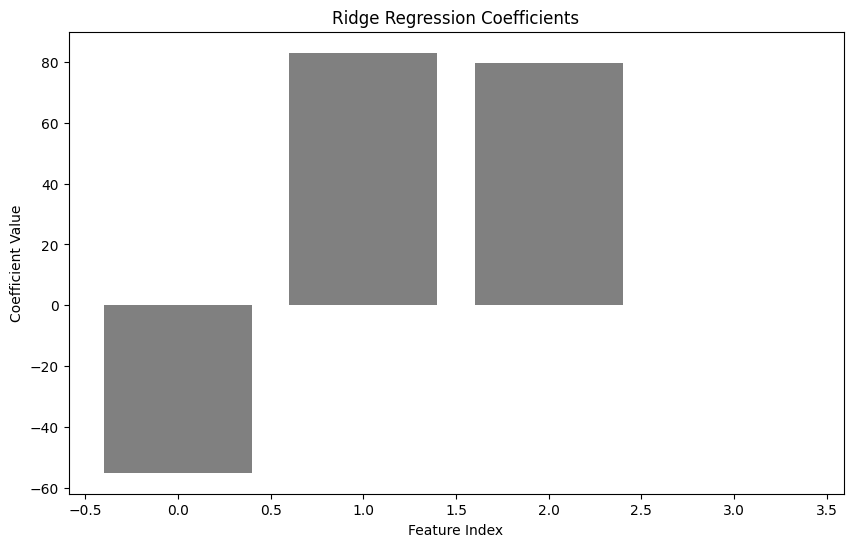

In [40]:
# Fit Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Get coefficients from Ridge Regression
ridge_coefficients = ridge.coef_

# Plotting Ridge Regression coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(ridge_coefficients)), ridge_coefficients, color='grey')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')
plt.show()

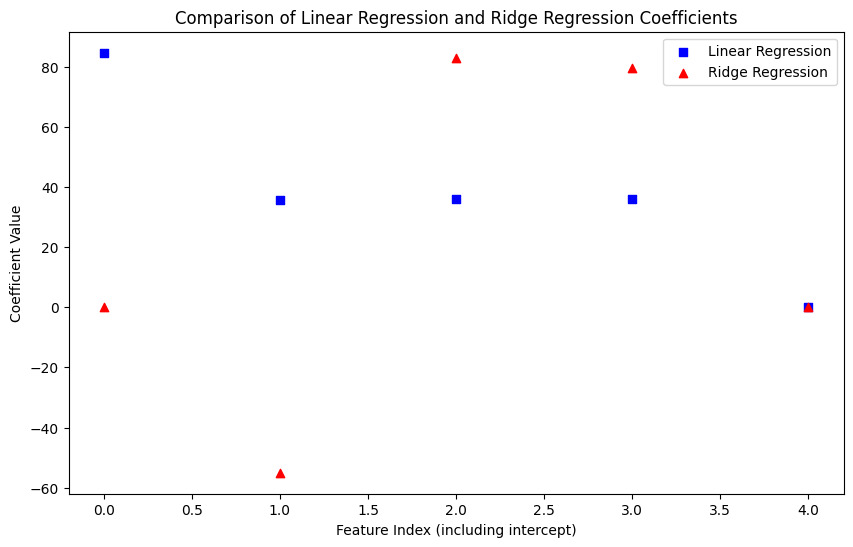

In [41]:
# Fit Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Get coefficients from Ridge Regression
ridge_coefficients = ridge.coef_

custom_reg = LinearRegression()
custom_reg.fit(X_train, y_train)

# Get coefficients for Linear Regression
linear_coefficients = custom_reg.weights
linear_intercept = custom_reg.bias

# Create indices for features (including the intercept)
n_features = len(linear_coefficients)
feature_indices = np.arange(n_features + 1)

# Scatter plot for Linear Regression coefficients
plt.figure(figsize=(10, 6))
plt.scatter(feature_indices, np.concatenate(([linear_intercept], linear_coefficients)), color='blue', label='Linear Regression',marker='s')

# Scatter plot for Ridge Regression coefficients
plt.scatter(feature_indices, np.concatenate(([0], ridge_coefficients)), color='red', label='Ridge Regression',marker='^')

plt.xlabel('Feature Index (including intercept)')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Linear Regression and Ridge Regression Coefficients')
plt.legend()
plt.show()

## Decision Tree

In [42]:
# Building and fitting the Decision Tree Model
decisionTree = DecisionTreeRegressor(random_state=42)
decisionTree.fit(X_train, y_train)
y_pred_dt = decisionTree.predict(X_test)
print(y_pred_dt)

[ 21.19  48.21  82.47 ...  41.13  32.63 100.97]


In [43]:
# Calculating metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Ridge Regression Mean Squared Error for Decision Tree Model: ", mse_dt)
print("R-squared for Decision Tree Model: ", r2_dt )

Ridge Regression Mean Squared Error for Decision Tree Model:  1.2206138902579322
R-squared for Decision Tree Model:  0.9998948742296446


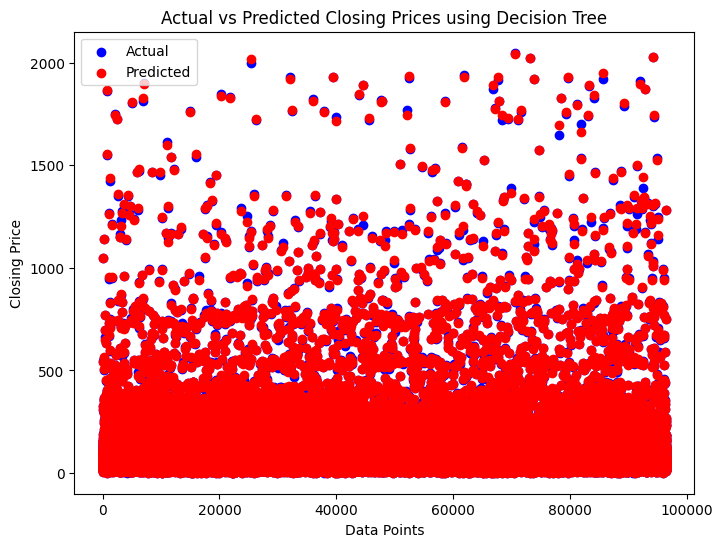

In [44]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred_dt)), y_pred_dt, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices using Decision Tree")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

## ARIMA - Autoregressive Integrated Moving Average

In [45]:
# Filter for a single stock, e.g., 'AAPL' since ARIMA is designed for univariate time series
df_aapl = df[df['Name'] == 'AAPL'].copy()

# Convert 'date' to datetime and set it as index for time series analysis
df_aapl['date'] = pd.to_datetime(df_aapl['date'])
df_aapl.set_index('date', inplace=True)

# Drop NaN values
df_aapl.dropna(inplace=True)

In [46]:
df_aapl.describe()

open         high          low        close        volume
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean    109.055429   109.951118   108.141589   109.066698  5.404790e+07
std      30.549220    30.686186    30.376224    30.556812  3.346835e+07
min      55.424200    57.085700    55.014200    55.789900  1.147592e+07
25%      84.647800    85.334950    84.250650    84.830650  2.969438e+07
50%     108.970000   110.030000   108.050000   109.010000  4.566893e+07
75%     127.335000   128.100000   126.290000   127.120000  6.870872e+07
max     179.370000   180.100000   178.250000   179.260000  2.668336e+08

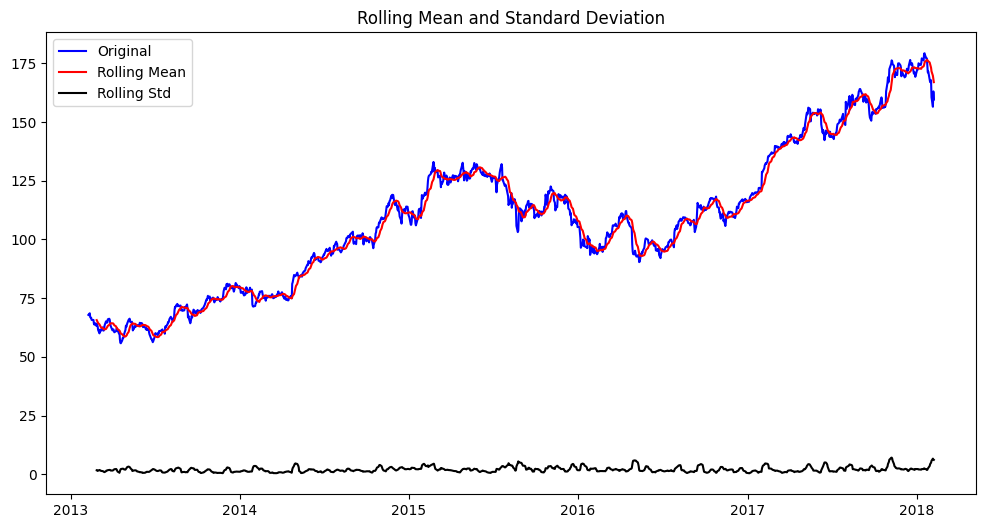

Results of Dickey-Fuller Test:
Test Statistics                  -0.665091
p-value                           0.855586
No. of lags used                  0.000000
Number of observations used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


In [47]:
# Function to test for stationarity in the time series
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plotting rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output['Critical Value (%s)' % key] = value
    print(output)

test_stationarity(df_aapl['close'])

<Figure size 1600x900 with 0 Axes>

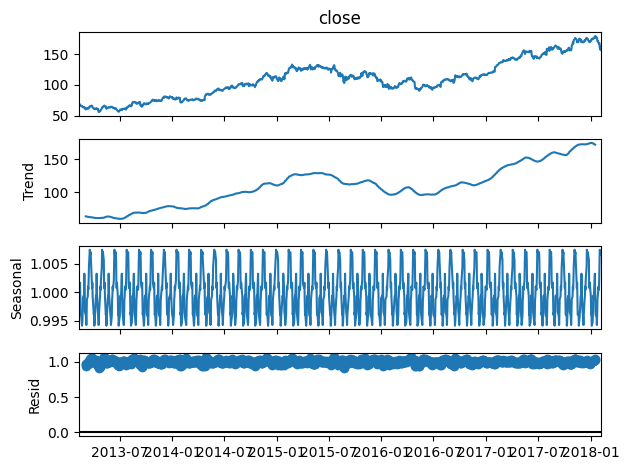

In [48]:
# Decompose the time series to observe its components
result = seasonal_decompose(df_aapl['close'], model='multiplicative', period=30)
plt.figure(figsize=(16, 9))
fig = result.plot()
plt.show()

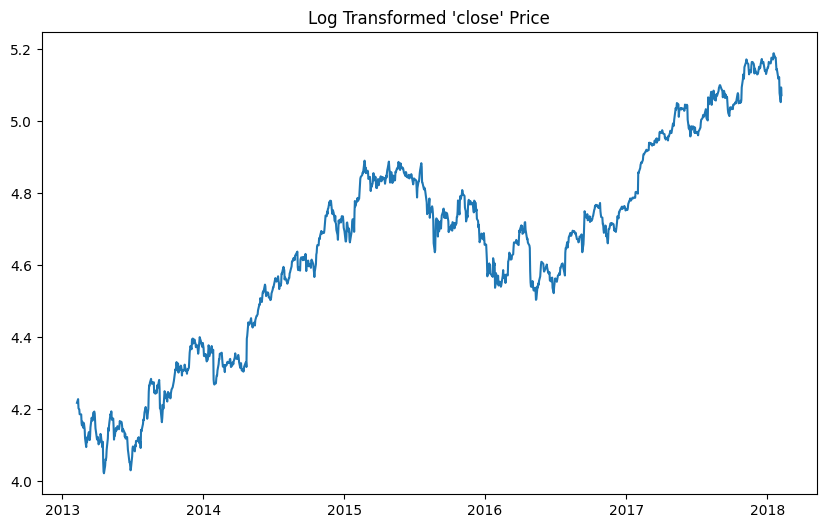

In [49]:
# Log transform 'close' price to stabilize variance
df_log = np.log(df_aapl['close'])
plt.figure(figsize=(10, 6))
plt.plot(df_log)
plt.title("Log Transformed 'close' Price")
plt.show()

In [50]:
# Split data into training and testing sets
train_data, test_data = df_log[3:int(len(df_log)*0.7)], df_log[int(len(df_log)*0.7):]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4796.337, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4799.459, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4798.334, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4798.330, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4800.364, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.723 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  878
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2401.182
Date:                Tue, 05 Dec 2023   AIC                          -4800.364
Time:                        00:35:53   BIC                          -4795.587
Sample:                             0   HQIC                         -4798.537
                                - 878                                  

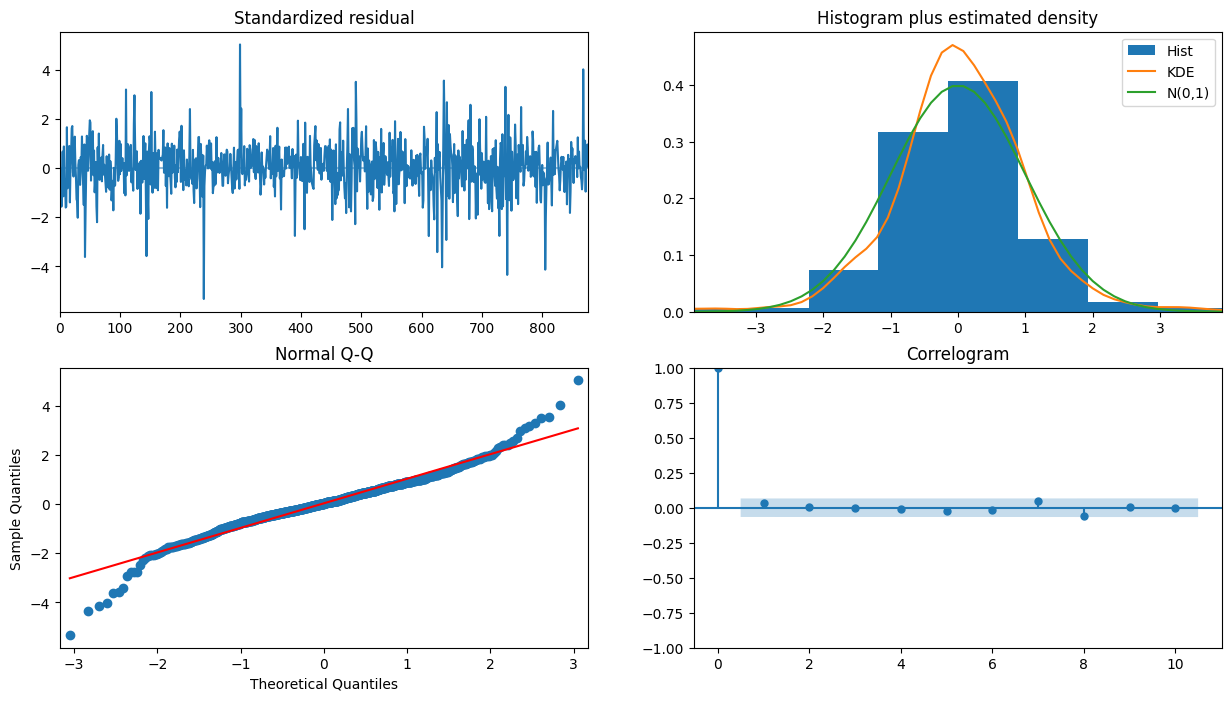

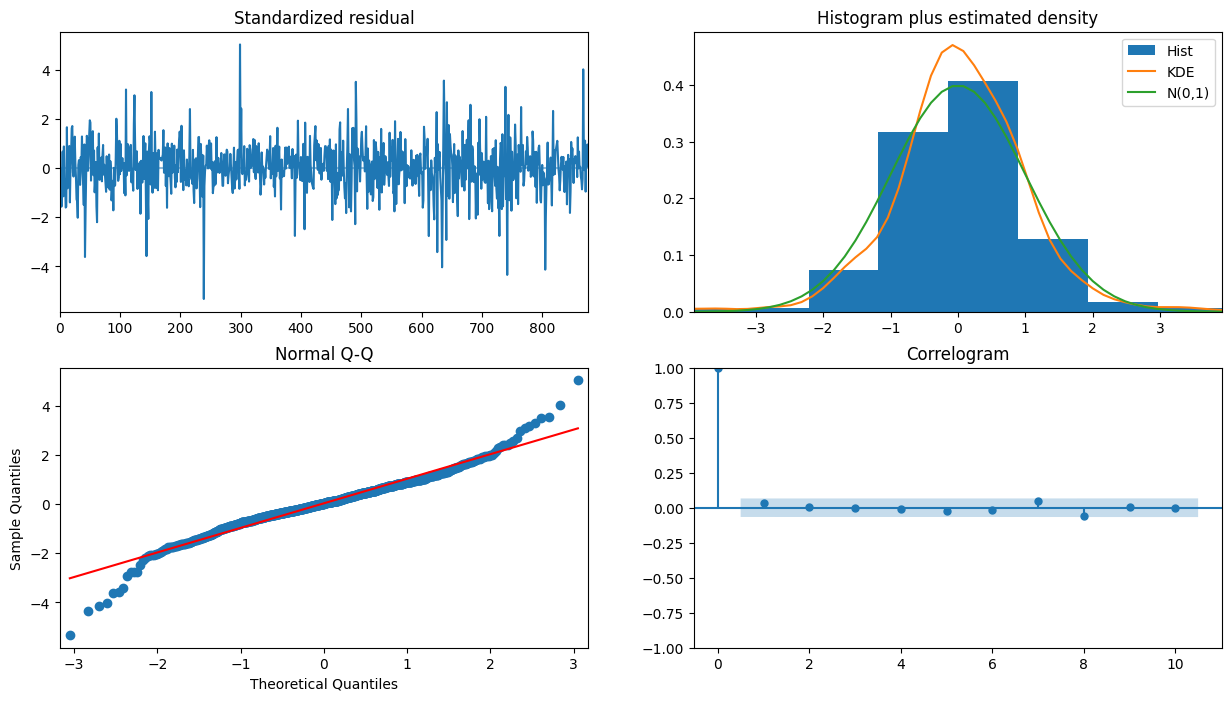

In [51]:
# Use auto_arima to determine the best ARIMA model parameters
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=2,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_autoARIMA.summary())

# Plot diagnostic figures to assess model adequacy
model_autoARIMA.plot_diagnostics(figsize=(15,8))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

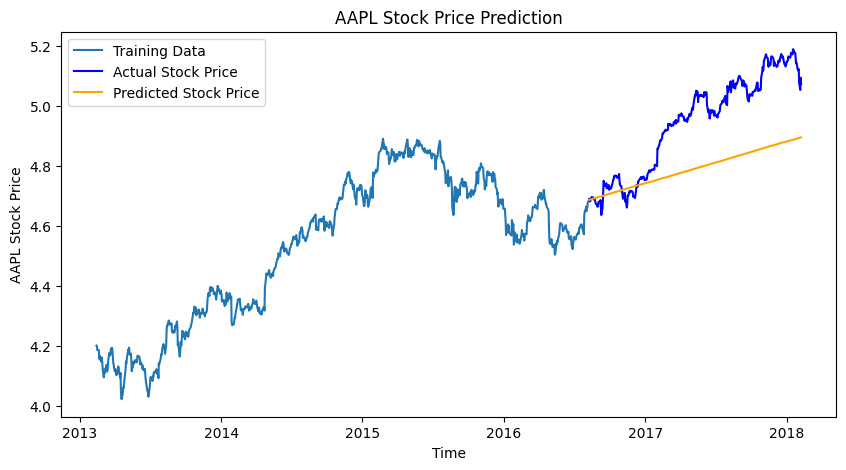

In [52]:
# Fit ARIMA model to the training data
model = ARIMA(train_data, order=(2,2,2))
fitted = model.fit()

# Forecasting future values using the ARIMA model
start = len(train_data)
end = start + len(test_data) - 1
fc = fitted.predict(start=start, end=end)

# Plotting the forecast against the actual values
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(test_data.index, fc, color='orange', label='Predicted Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

In [53]:
# Calculate performance metrics
mse = mean_squared_error(test_data, fc)

print('MSE of ARIMA Model:', mse)

MSE of ARIMA Model: 0.033771689437878824


## Principal Component Regression

In [54]:
# Adding moving average as a new feature
filtered_df = df[df['Name'].isin(top_10_stocks)].copy()
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['moving_average'] = filtered_df.groupby('Name')['close'].transform(lambda x: x.rolling(window=5).mean())

# Dropping NaN values created by moving average calculation
filtered_df.dropna(inplace=True)

In [55]:
# Selecting features and target variable
X = filtered_df[['open', 'high', 'low', 'volume', 'moving_average']].values
y = filtered_df['close'].values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# Applying PCA
pca = PCA(n_components=3)  # Using 3 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [57]:
# Fit Linear Regression model on the principal components
pcr_model = LinearRegression()
pcr_model.fit(X_train_pca, y_train)

# Predict using PCR model
y_pred_pcr = pcr_model.predict(X_test_pca)

In [58]:
# Evaluate the model
mse_pcr = mean_squared_error(y_test, y_pred_pcr)
r2_pcr = r2_score(y_test, y_pred_pcr)

print("MSE for PCR:", mse_pcr)
print("R-squared for PCR:", r2_pcr)

MSE for PCR: 0.24263418877811388
R-squared for PCR: 0.9998326496305456


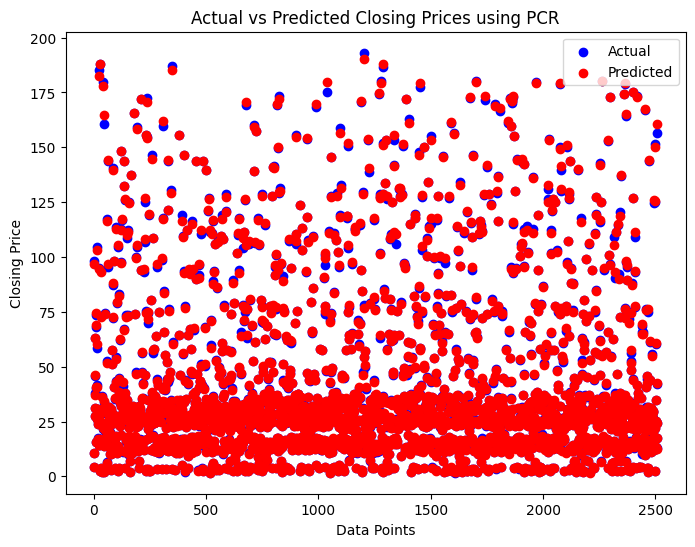

In [59]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred_pcr)), y_pred_pcr, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices using PCR")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

### SARIMA - Seasonal Autoregressive Integrated Moving Average

In [60]:
# Use auto_arima to determine the best SARIMA model parameters
model_autoSARIMA = auto_arima(train_data, start_p=0, start_q=0,
                              test='adf',       # use adftest to find optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=30,             # frequency of series (seasonal period)
                              d=None,           # let model determine 'd'
                              seasonal=True,    # Seasonality
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(model_autoSARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=-4797.442, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-4799.459, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-4796.504, Time=1.84 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-4796.373, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-4800.364, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=-4797.603, Time=2.23 sec
 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=-4795.695, Time=1.98 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=-4798.334, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=-4798.330, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=-4796.337, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[30]          
Total fit time: 8.754 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  878
Model:               SARIMAX(0, 1, 0)   L

In [61]:
P, D, Q, m = 1, 1, 1, 12

# Fit SARIMA model (using the SARIMAX class)
model_sarima = SARIMAX(train_data,
                       order=(0,1,0),              # Non-seasonal parameters
                       seasonal_order=(P, D, Q, m),# Seasonal parameters
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results_sarima = model_sarima.fit()

# Summary of the model
print(results_sarima.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                close   No. Observations:                  878
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                2304.897
Date:                              Tue, 05 Dec 2023   AIC                          -4603.795
Time:                                      00:36:06   BIC                          -4589.552
Sample:                                           0   HQIC                         -4598.340
                                              - 878                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0162      0.036     -0.443      0.658      -0.088       0.055
ma.S.L12      -1.00

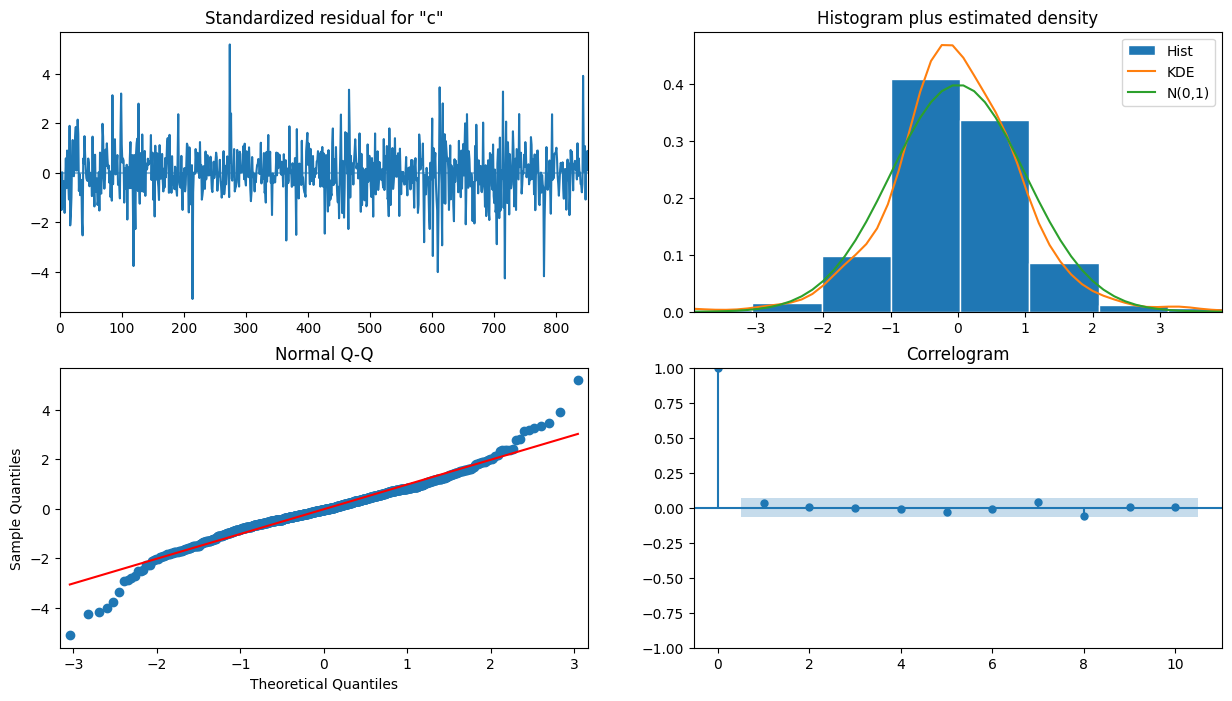

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [62]:
# Diagnostics plot
results_sarima.plot_diagnostics(figsize=(15, 8))
plt.show()

# Forecasting future values using the SARIMA model
fc_sarima = results_sarima.predict(start=start, end=end)

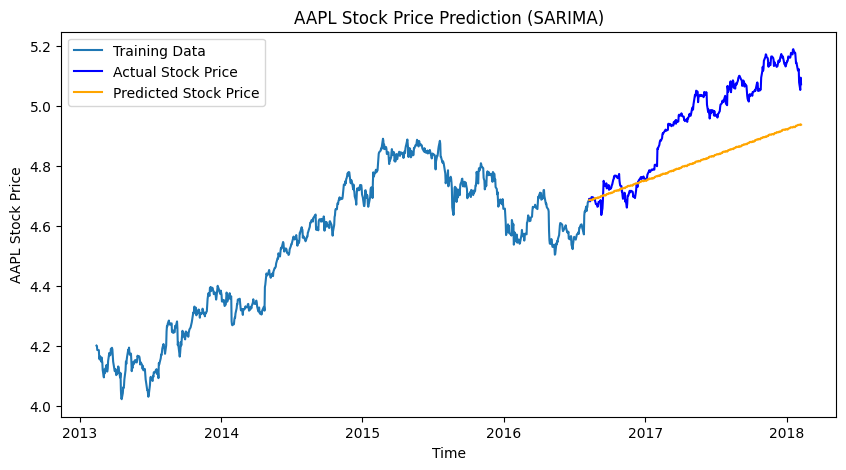

In [63]:
# Plotting the forecast against the actual values
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(test_data.index, fc_sarima, color='orange', label='Predicted Stock Price')
plt.title('AAPL Stock Price Prediction (SARIMA)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

In [64]:
# Calculate performance metrics for SARIMA
mse_sarima = mean_squared_error(test_data, fc_sarima)
print('MSE of SARIMA Model:', mse_sarima)

MSE of SARIMA Model: 0.02560742607953426
